## Zadanie 1: Algorytm k-średnich

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('spirala.txt', delimiter=r'\s+', header=None)
df.columns = ['x', 'y']
df

x       y
0   -0.0824  0.9435
1   -0.0824  0.9435
2    0.0913  0.9575
3    0.0476  1.0683
4    0.2311  1.0452
..      ...     ...
97  -0.5031  1.8191
98  -0.3340  1.8515
99  -0.3200  1.9158
100 -0.2074  1.9929
101  0.0322  1.9473

[102 rows x 2 columns]

In [3]:
m = 4
iters = 100

In [4]:
V = df.sample(m)  # 1. Wybierz losowo m różnych próbek i uznaj je jako środki grup (V)
V

x       y
66 -1.3366 -0.8821
12  0.8030  0.8494
45  0.4944 -1.2617
30  1.3287 -0.2480

In [5]:
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

In [6]:
def draw_current_iteration(df, V, u_s, iteration):
    plt.clf()
    colors = ['blue', 'lime', 'cyan', 'magenta']
    
    for i in range(len(V)):
        points = df[u_s == i]
        plt.scatter(points['x'].values, points['y'].values, color=colors[i], label=f'Grupa {i}')
    
    plt.scatter(V['x'].values, V['y'].values, color='red', marker='x', s=100, label='Środki grup')
    plt.title(f'Iteration {iteration + 1}')
    plt.legend()
    plt.show()

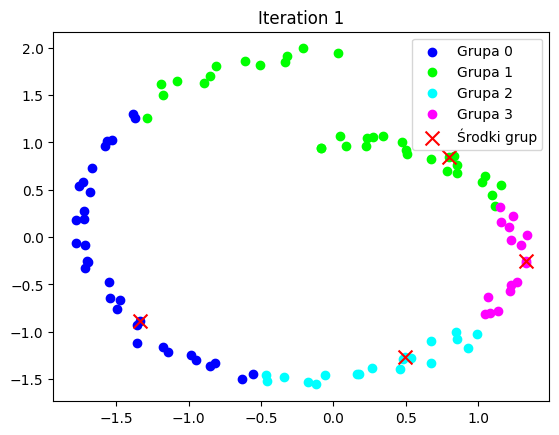

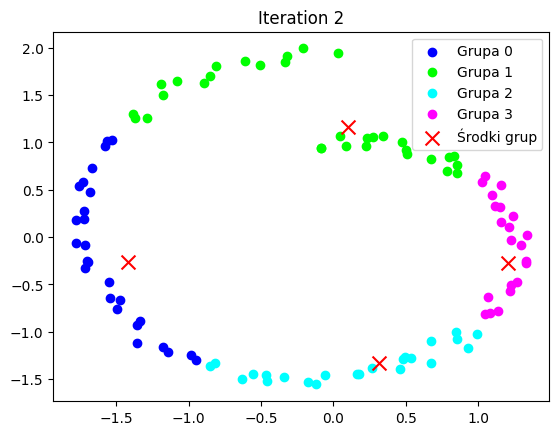

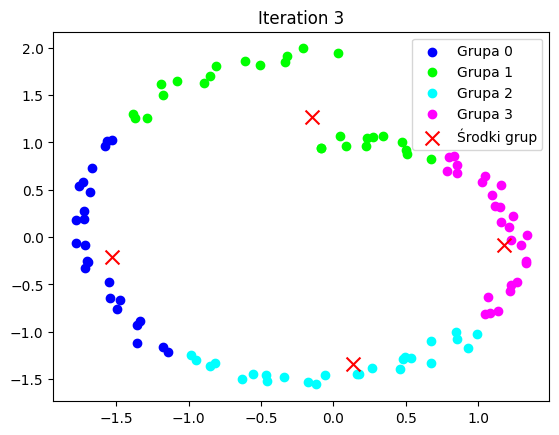

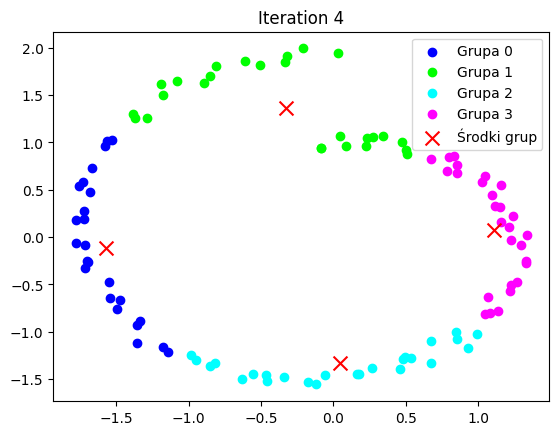

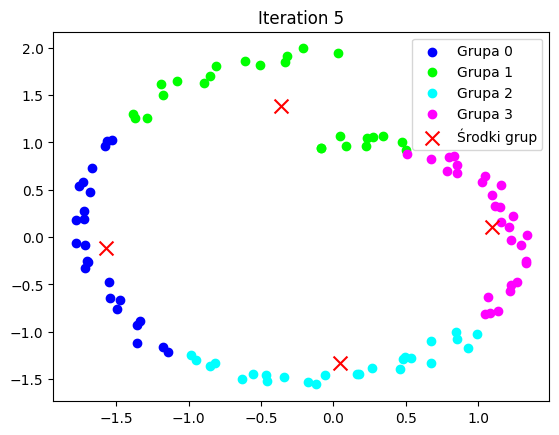

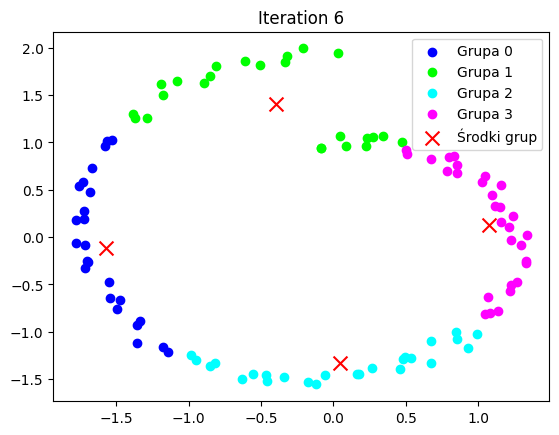

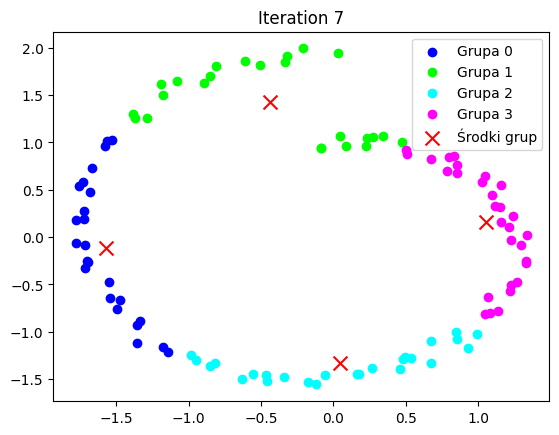

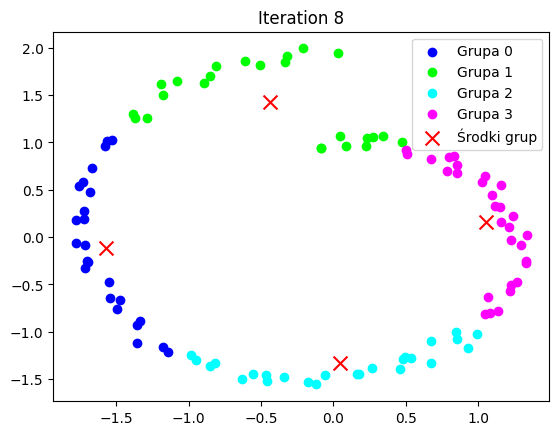

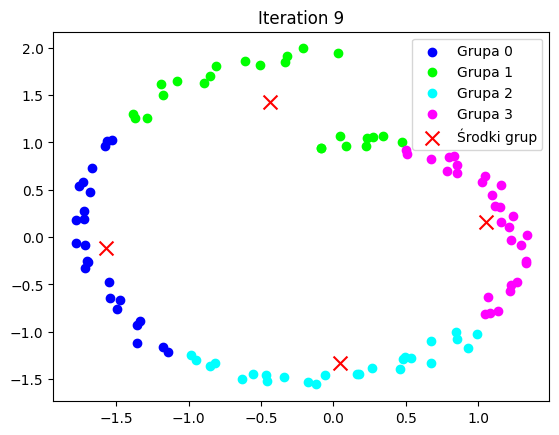

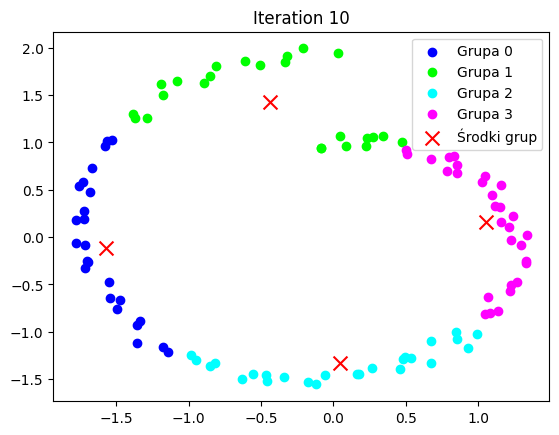

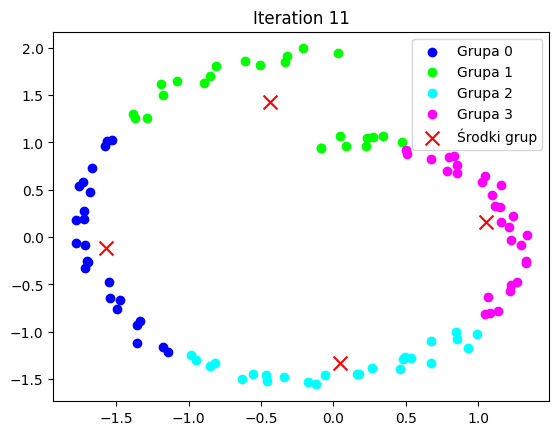

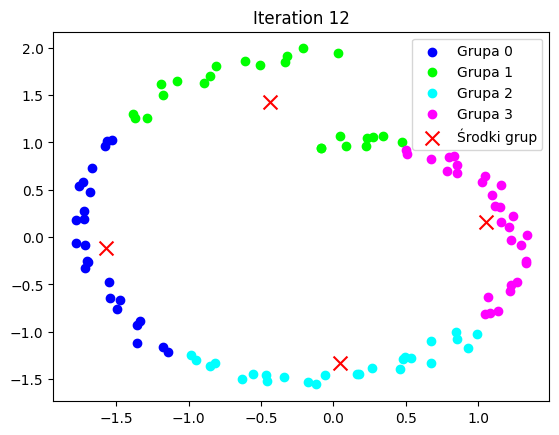

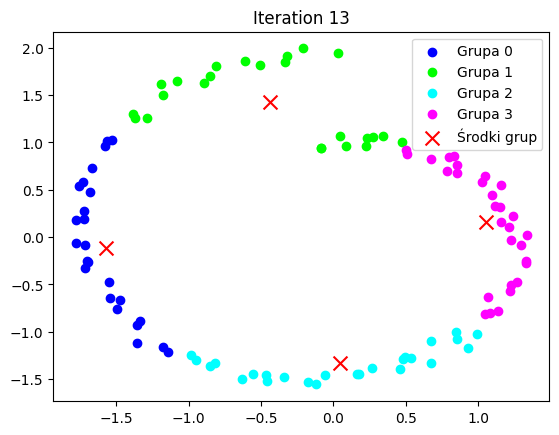

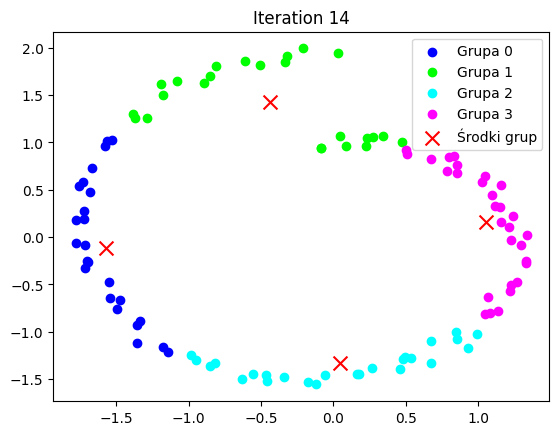

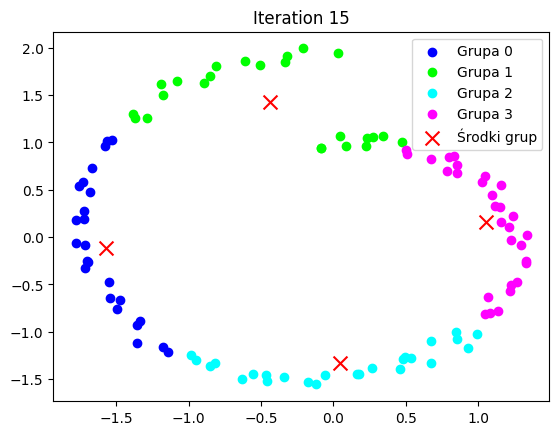

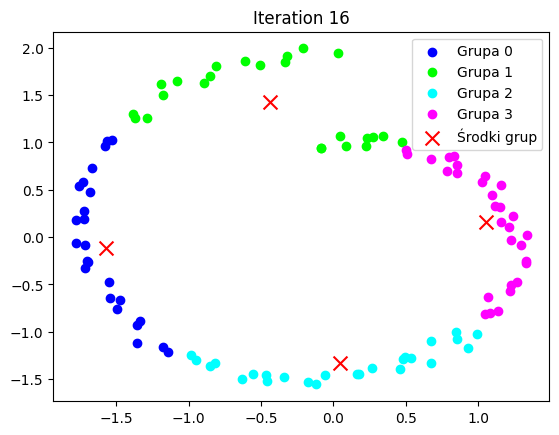

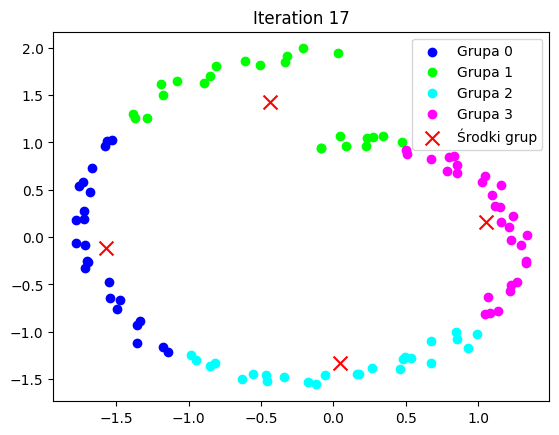

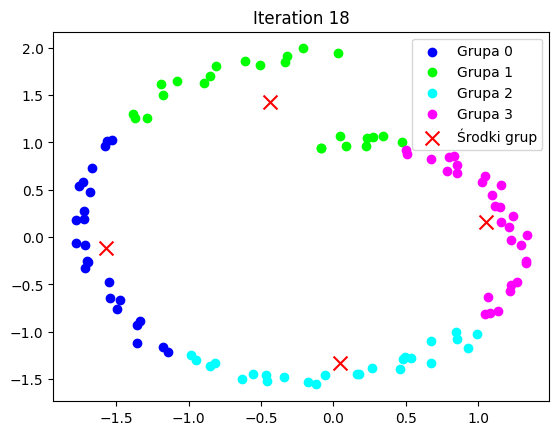

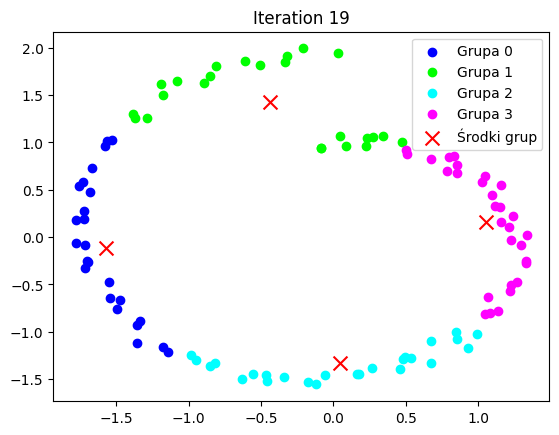

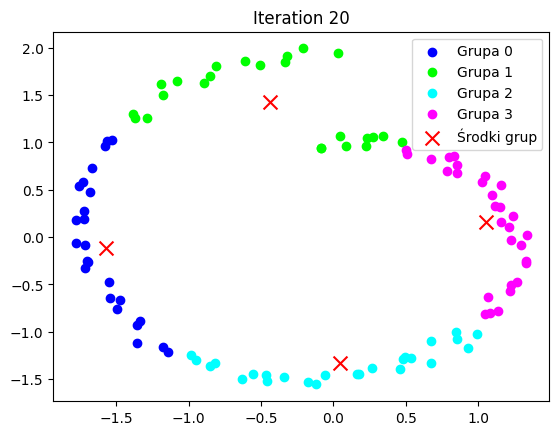

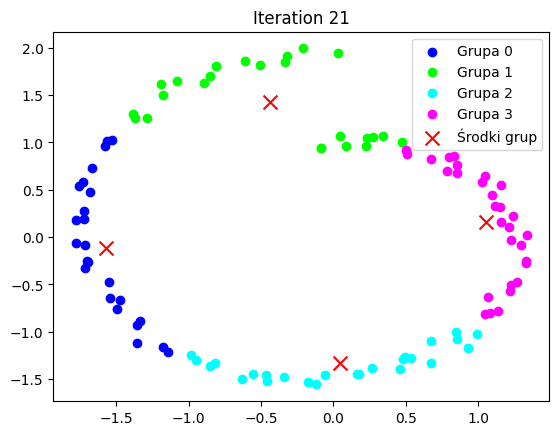

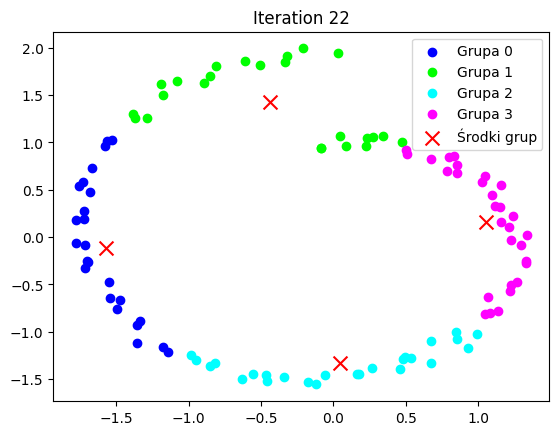

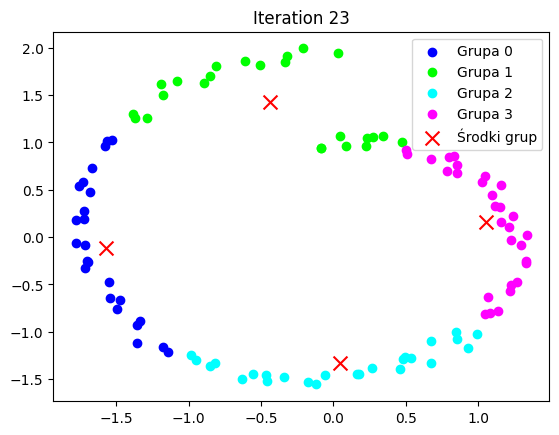

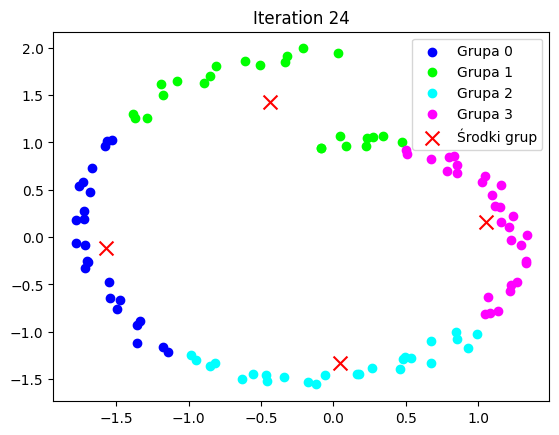

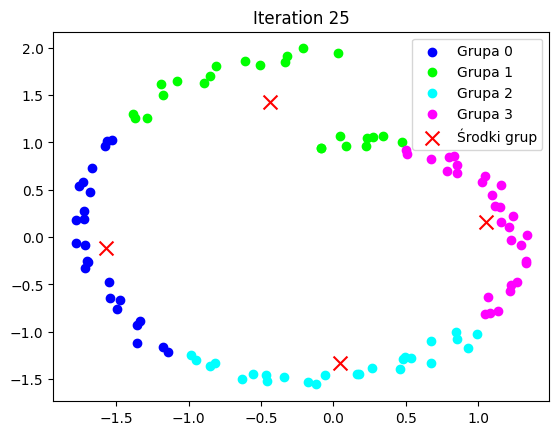

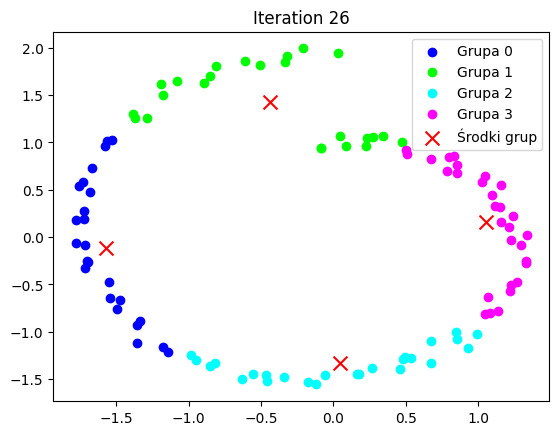

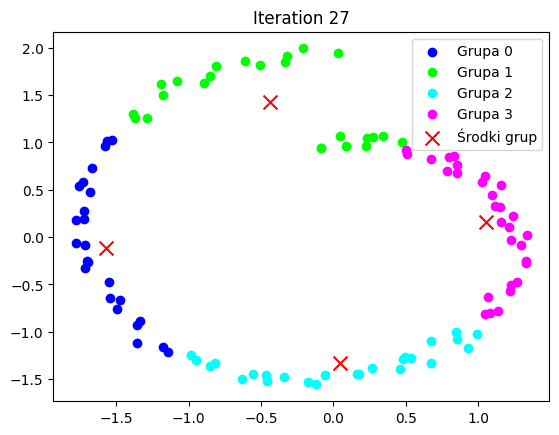

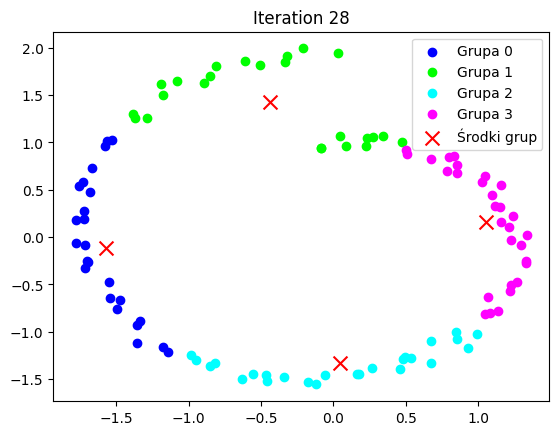

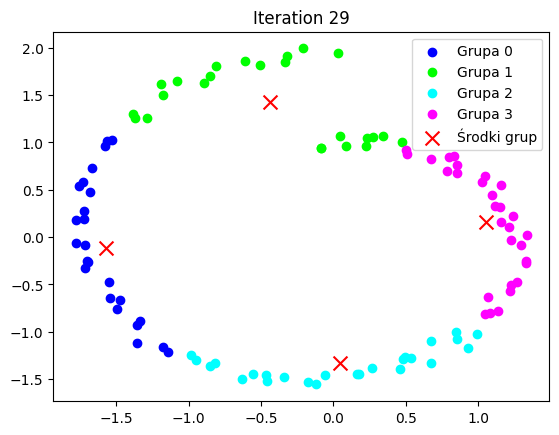

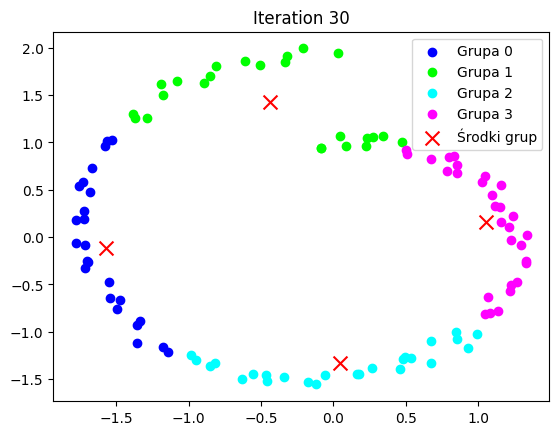

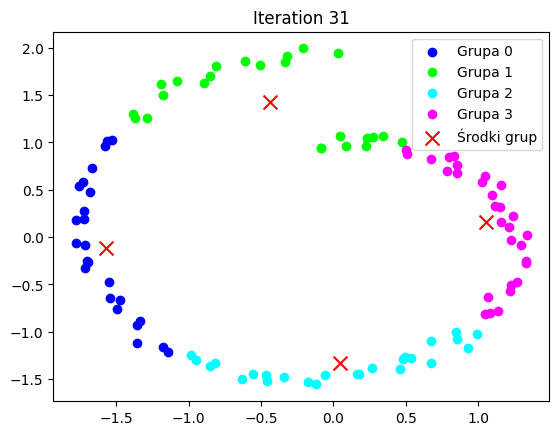

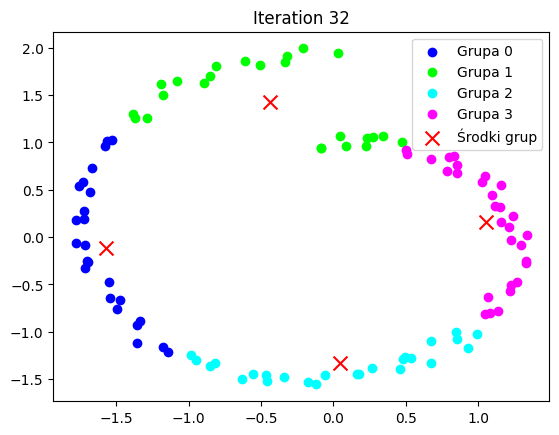

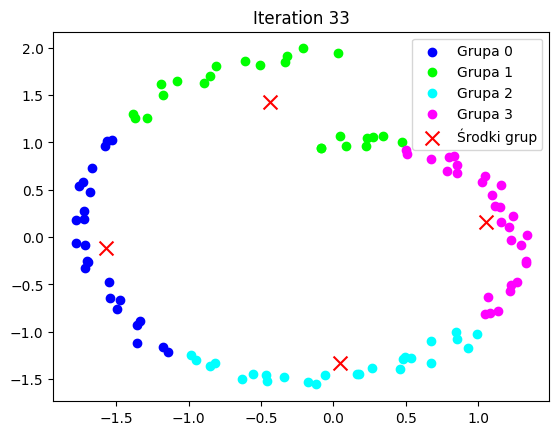

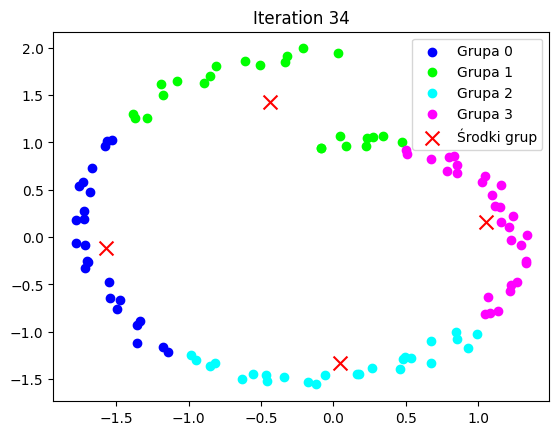

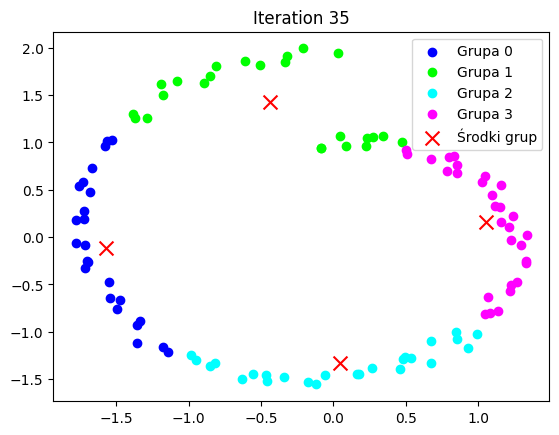

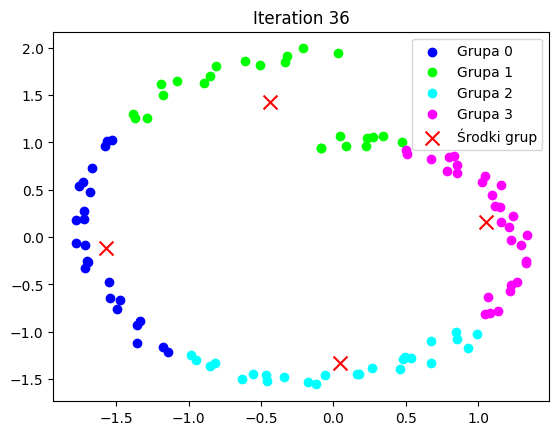

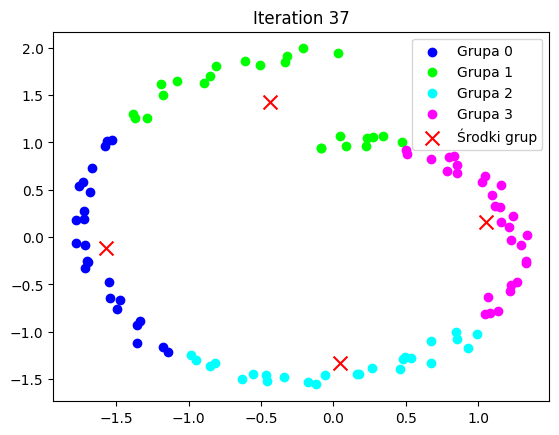

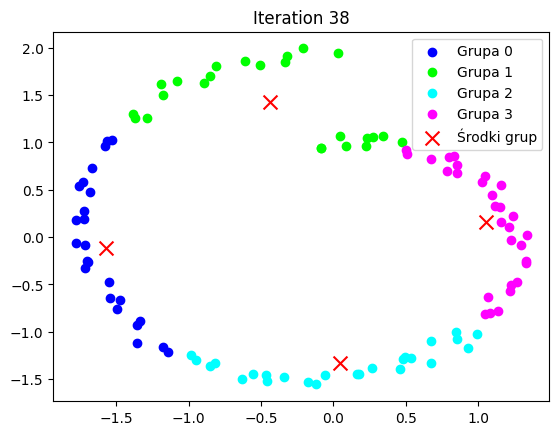

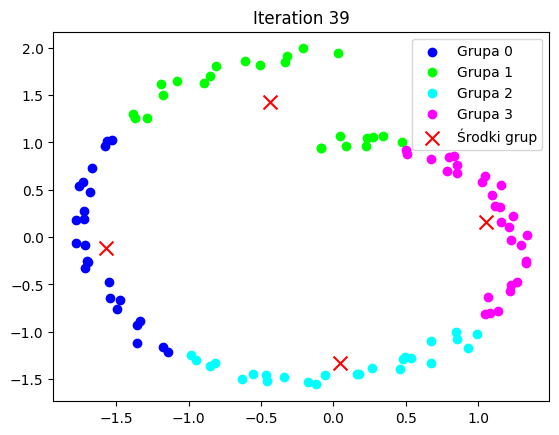

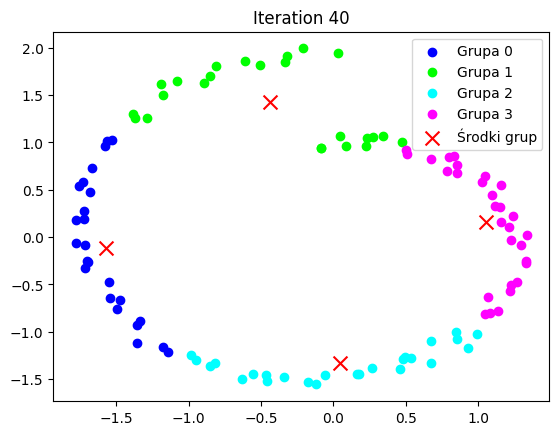

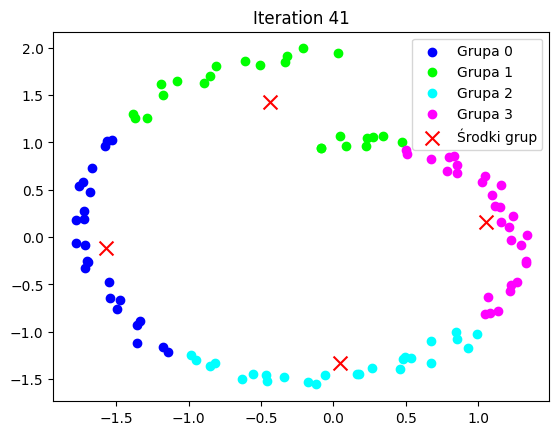

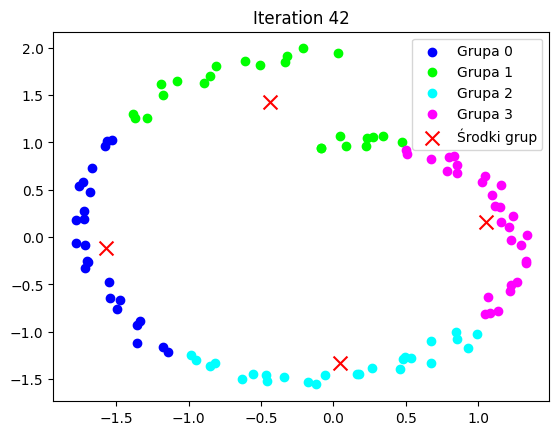

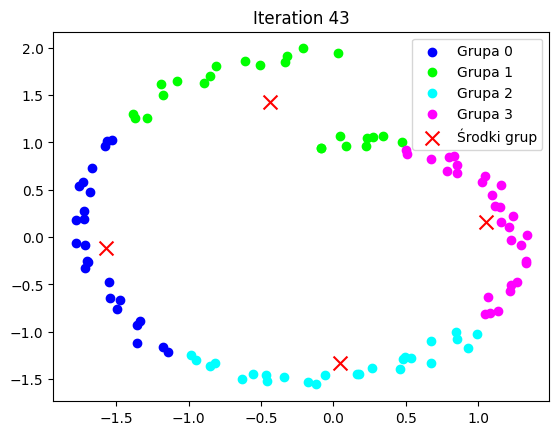

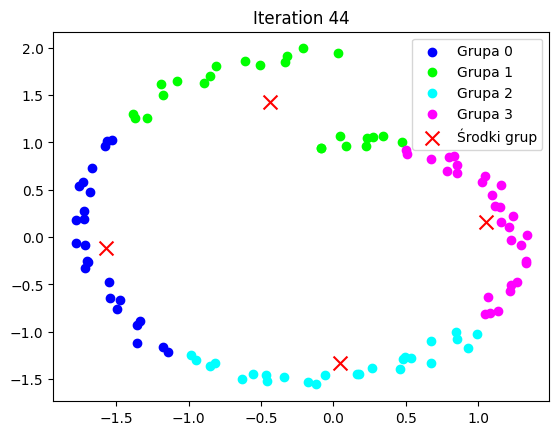

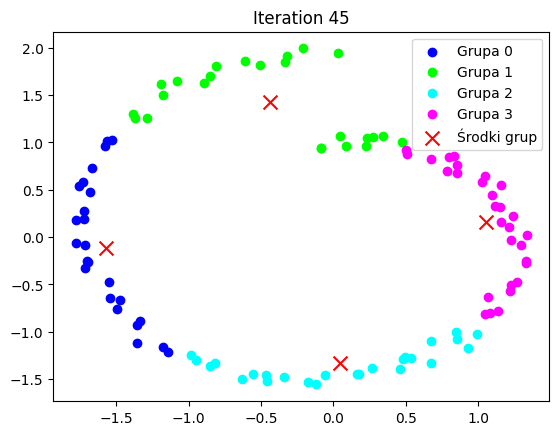

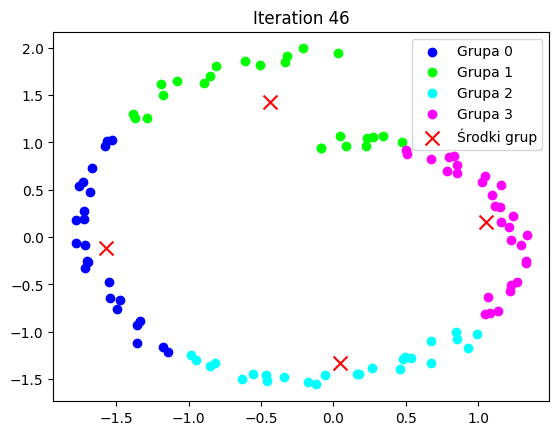

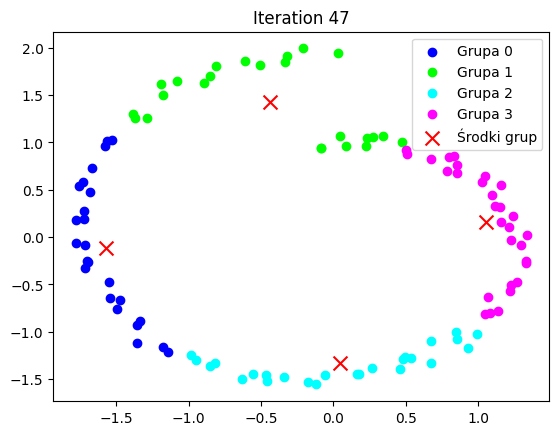

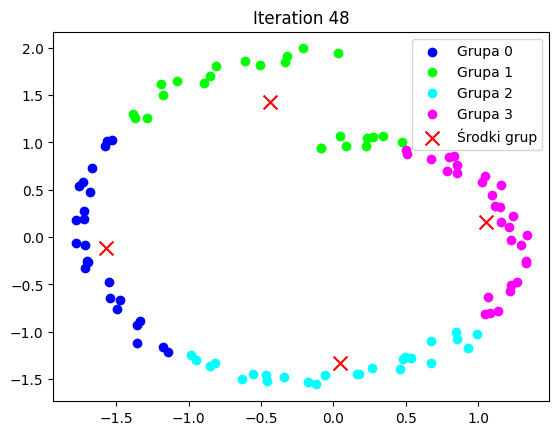

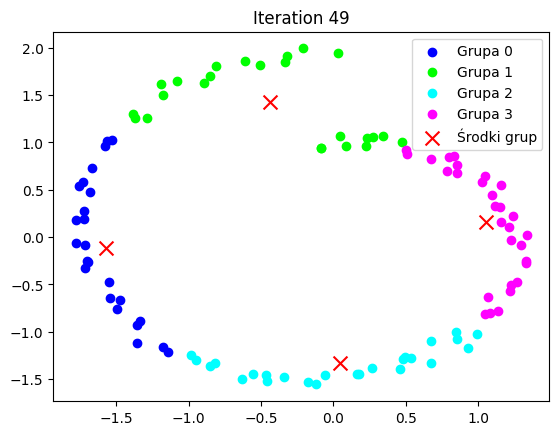

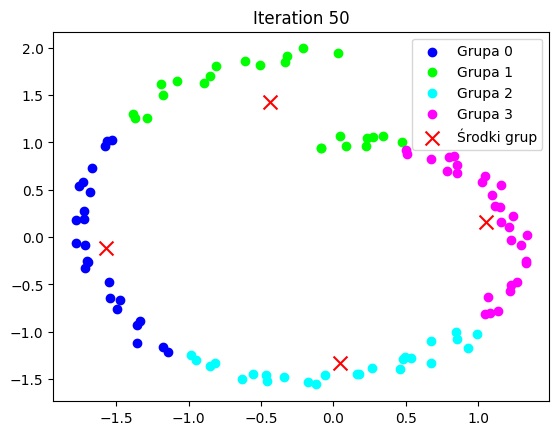

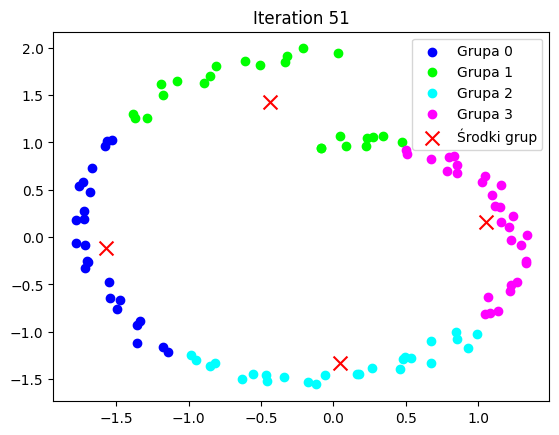

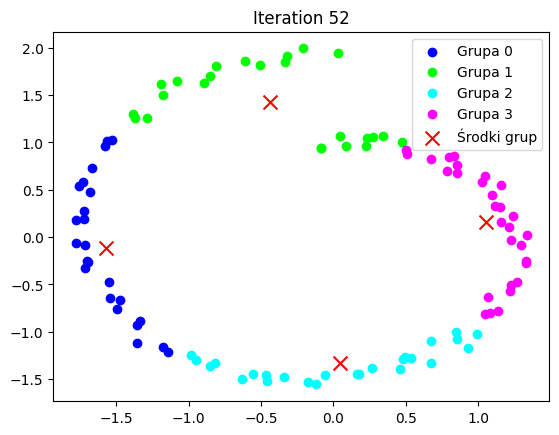

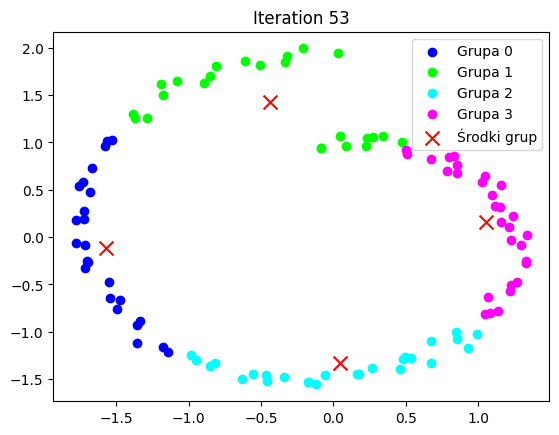

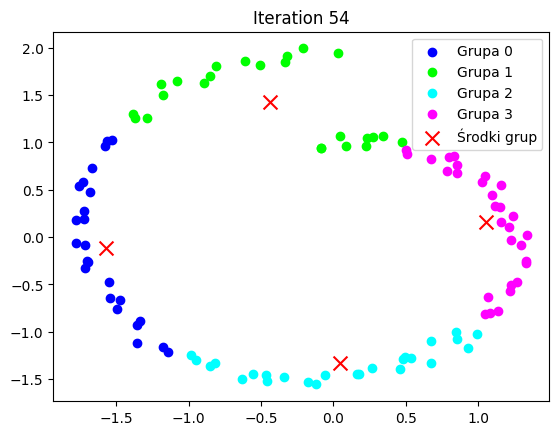

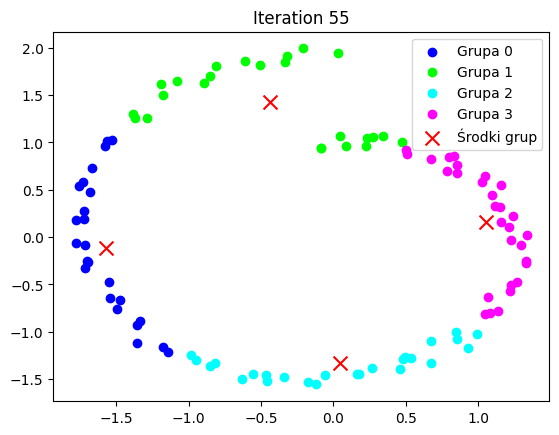

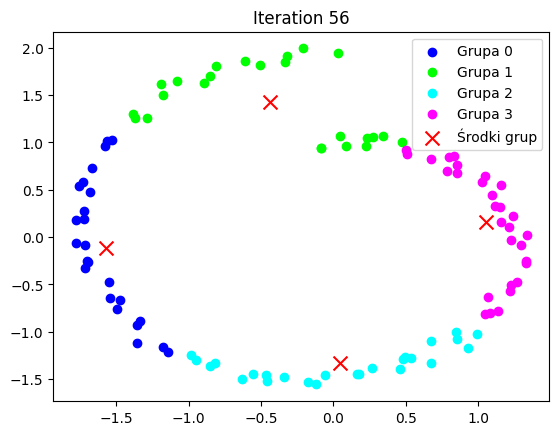

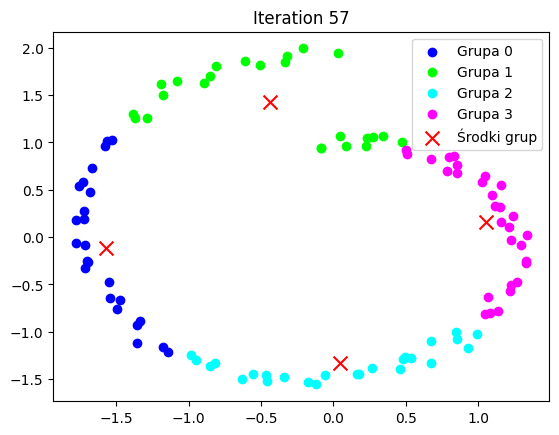

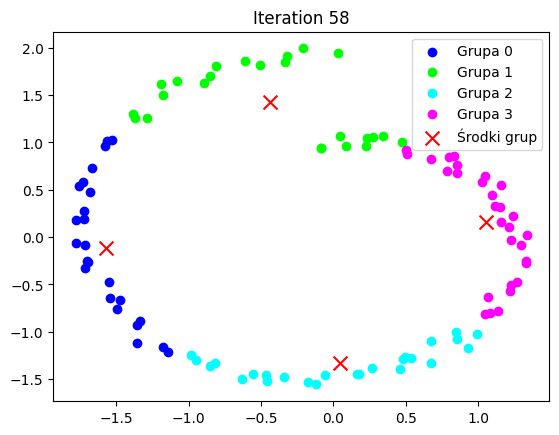

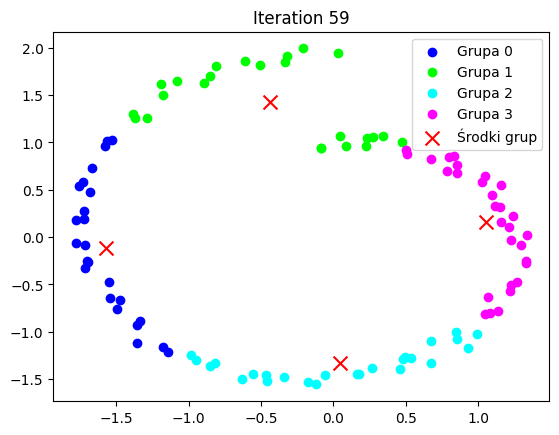

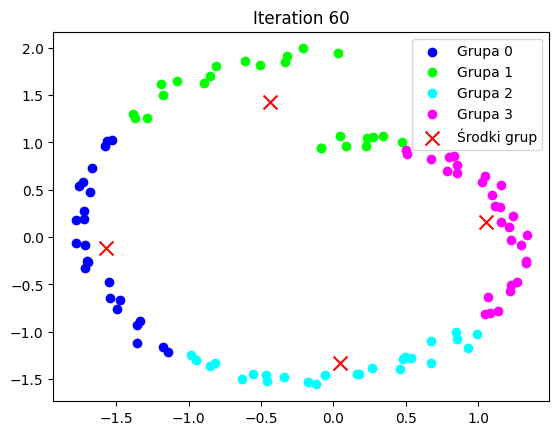

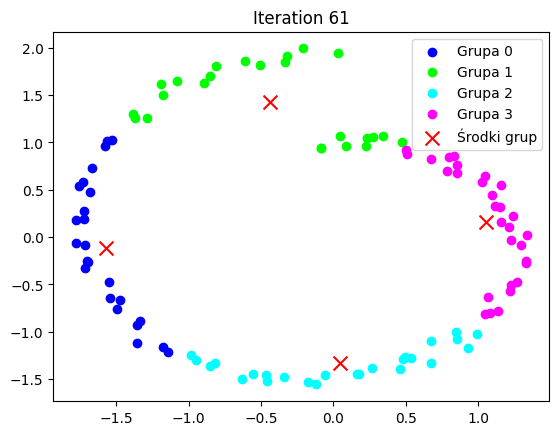

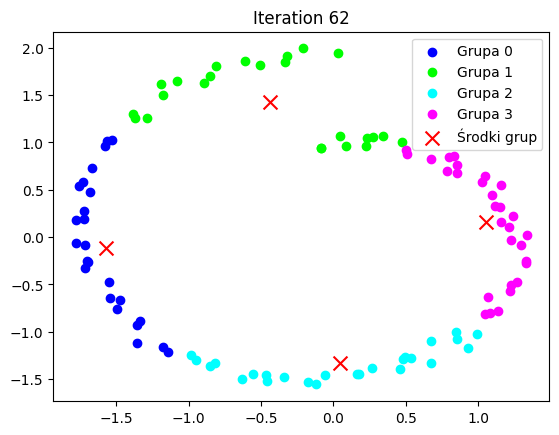

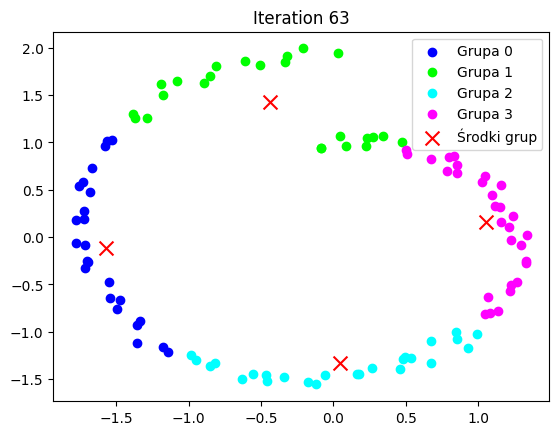

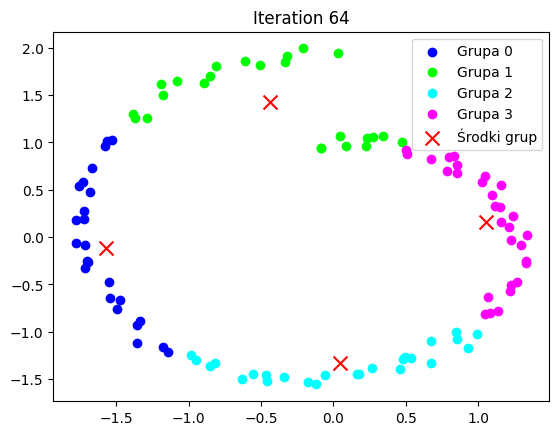

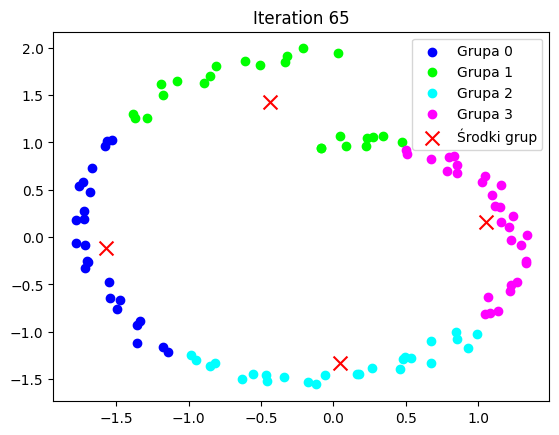

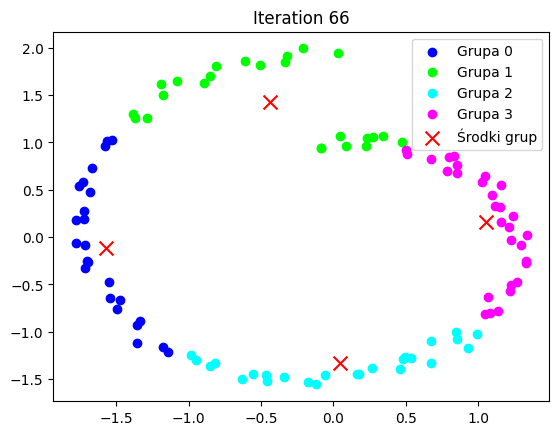

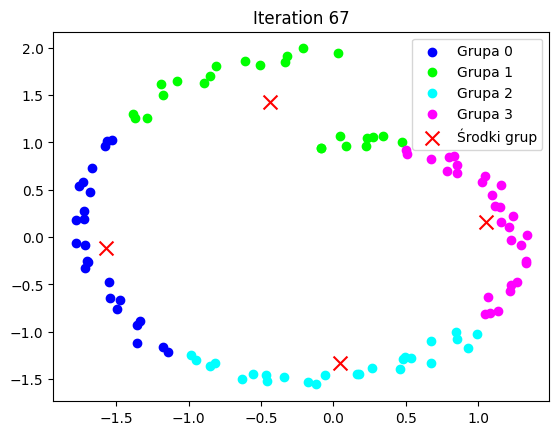

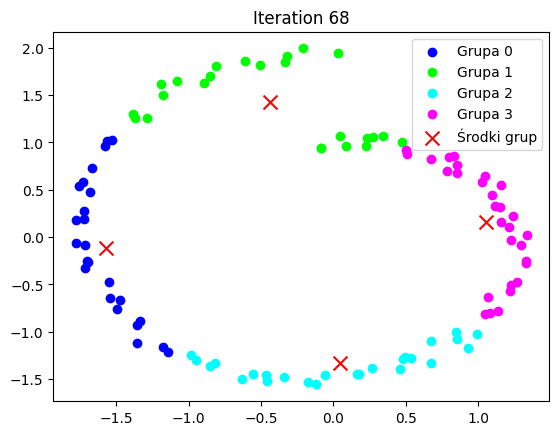

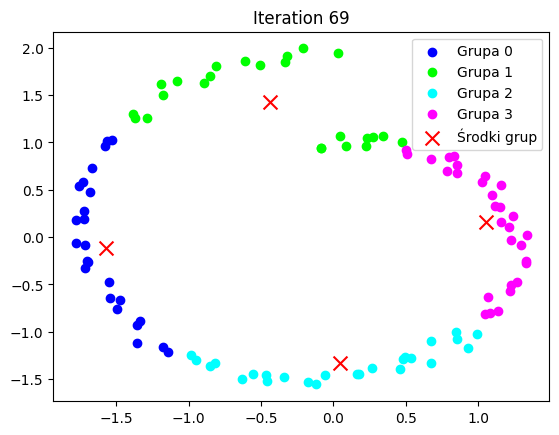

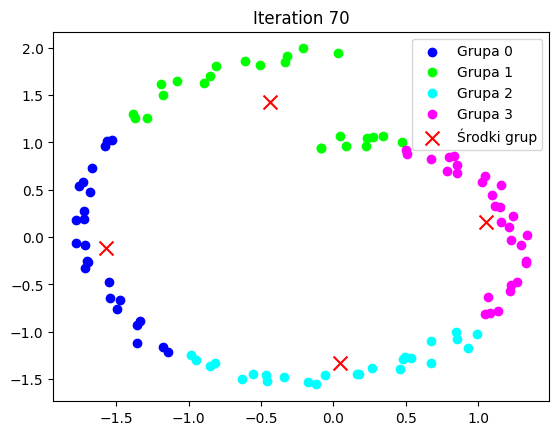

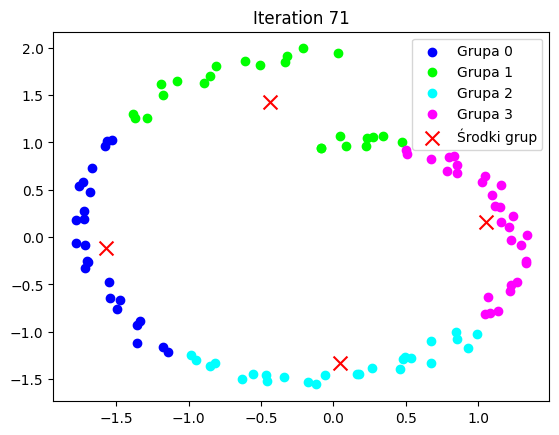

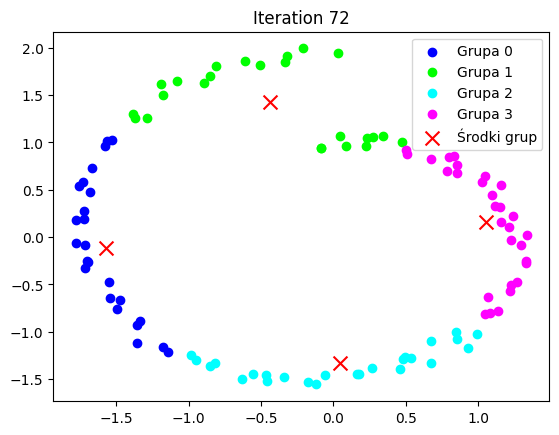

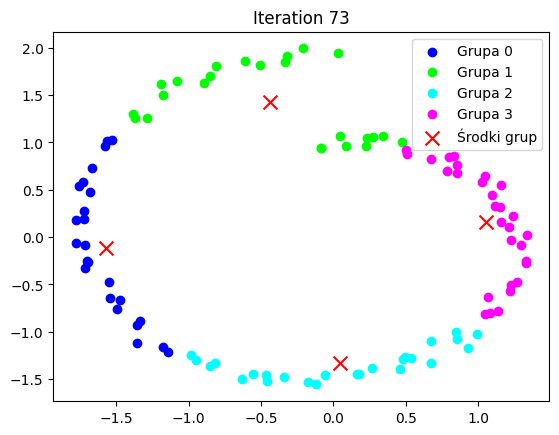

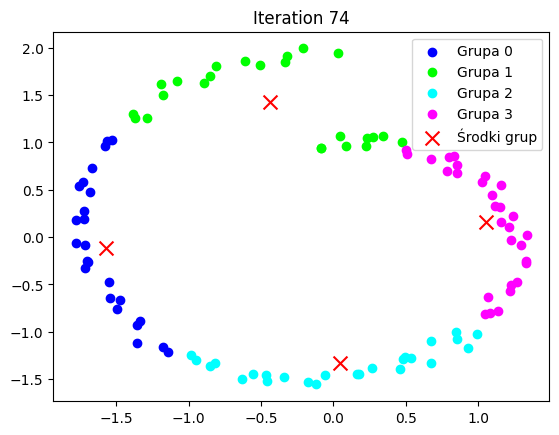

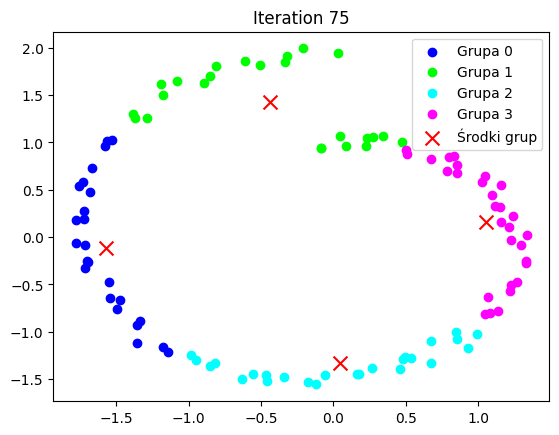

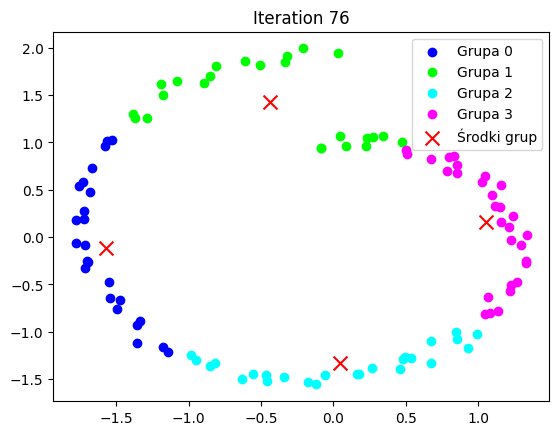

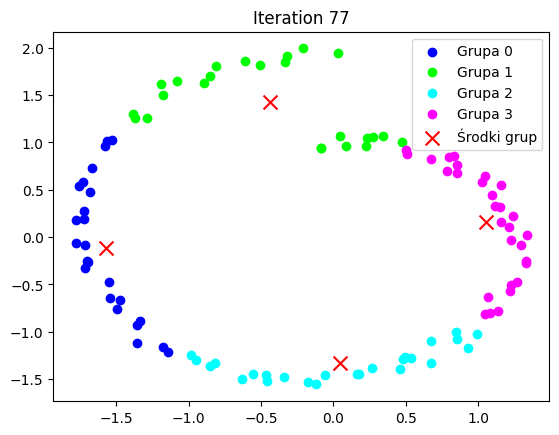

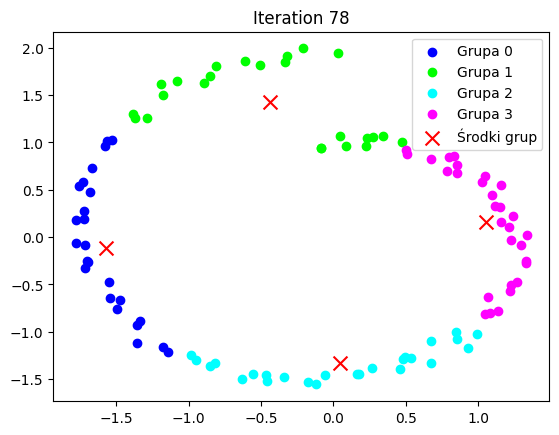

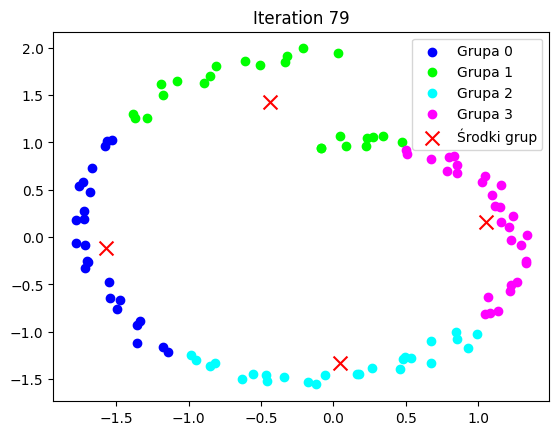

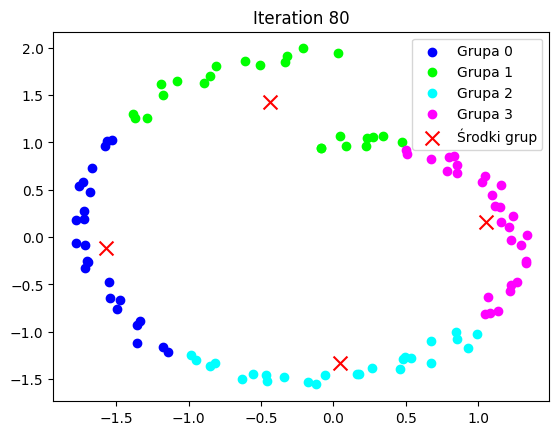

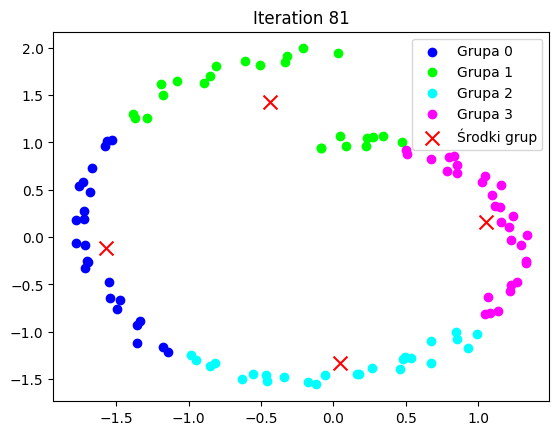

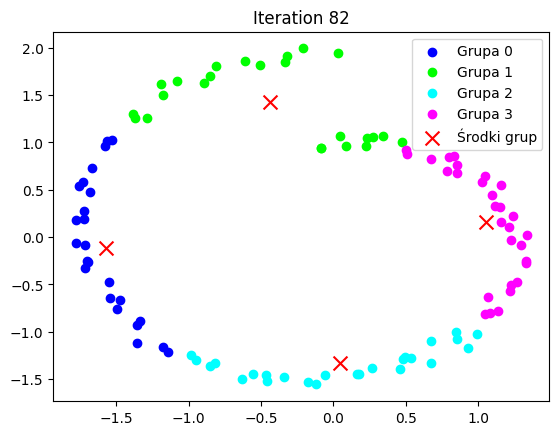

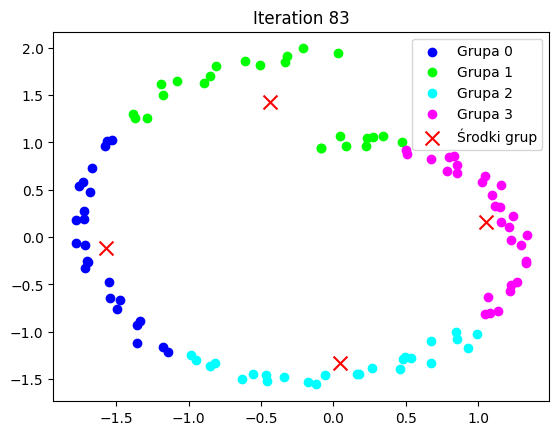

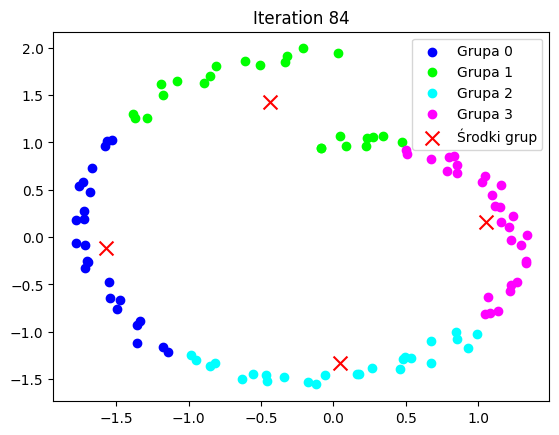

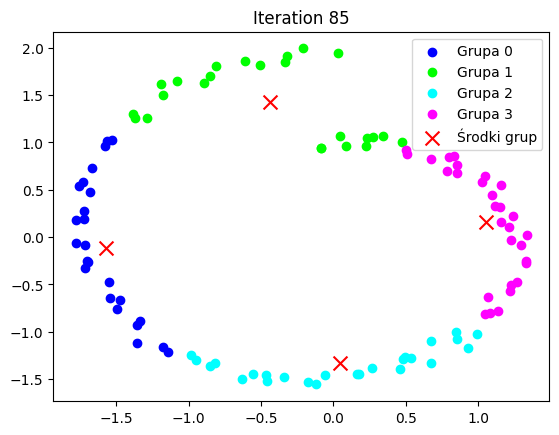

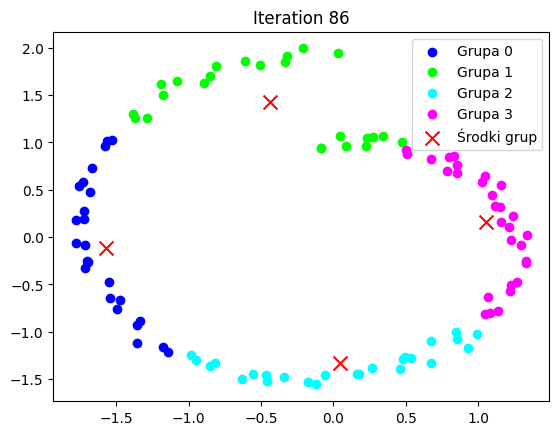

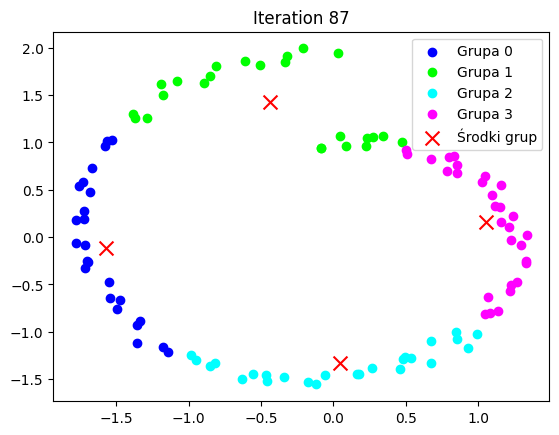

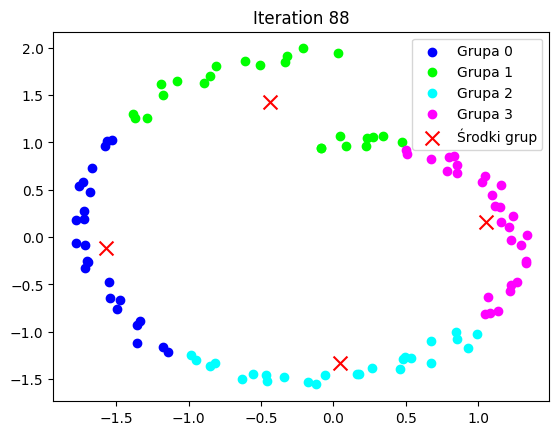

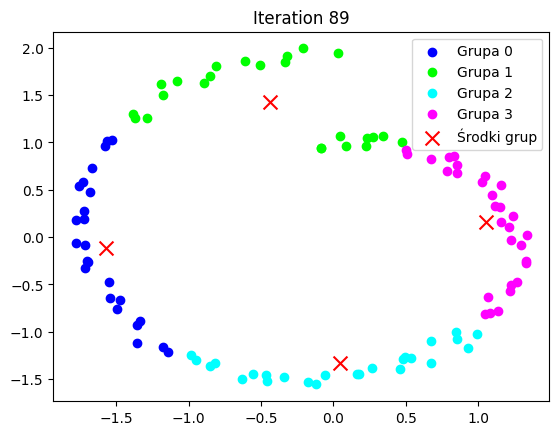

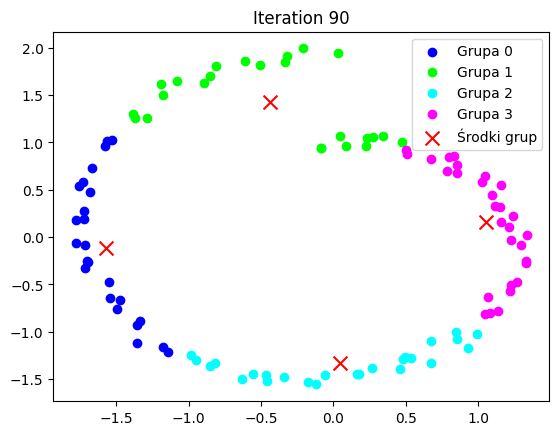

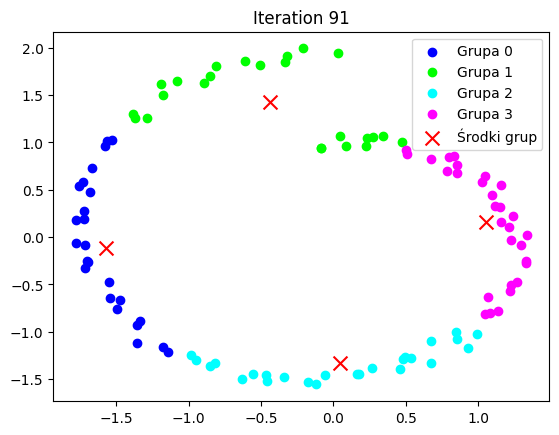

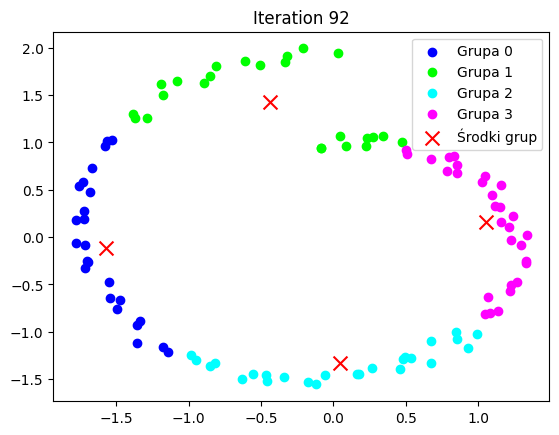

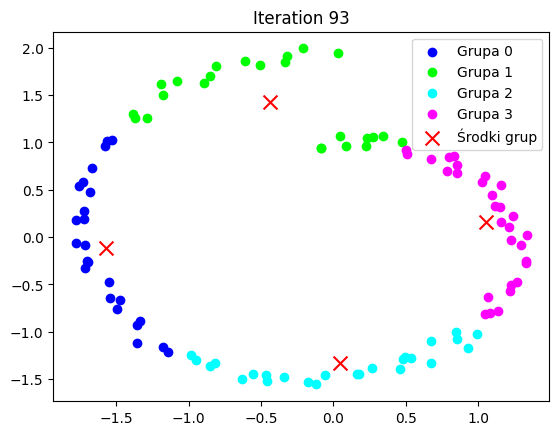

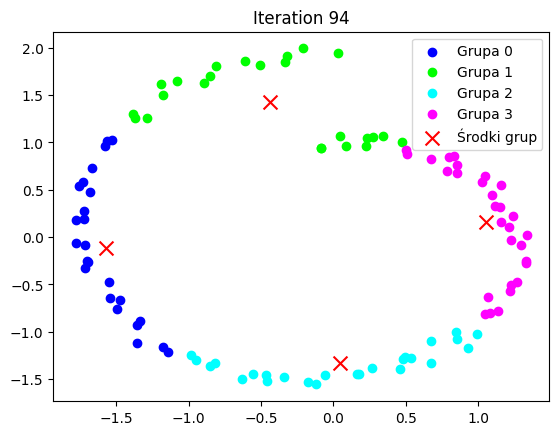

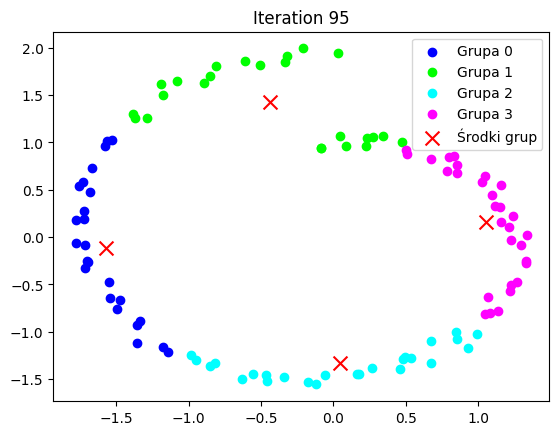

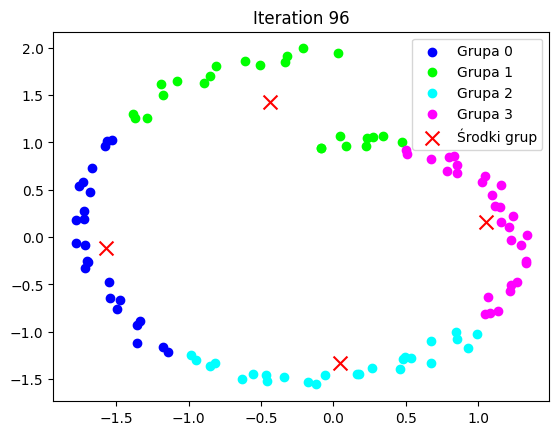

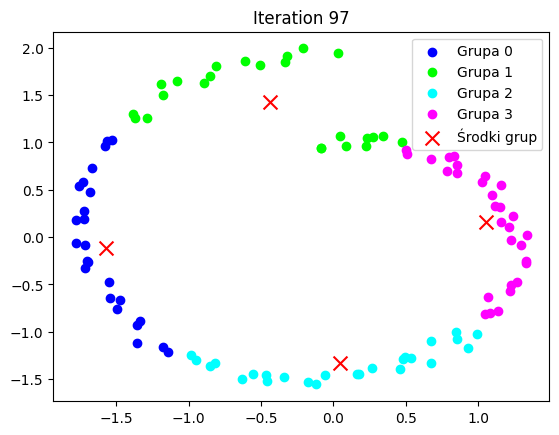

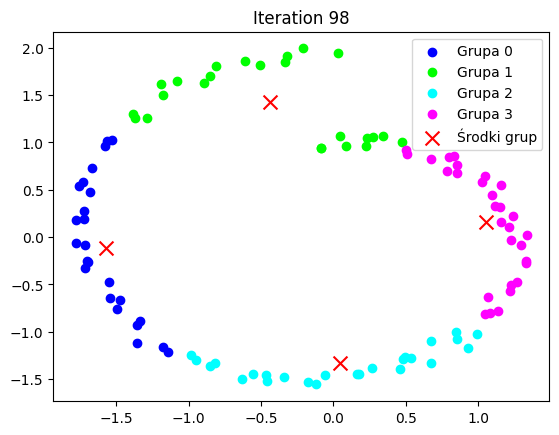

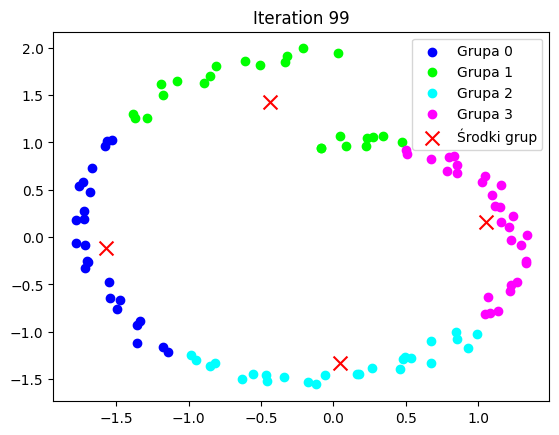

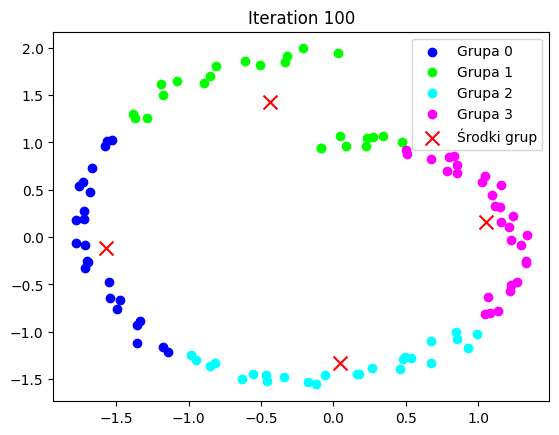

In [7]:
for iteration in range(iters):  # 2. Pętla wykonywana zadaną liczbę iteracji (iters)
    u_s = np.zeros(df.shape[0])
    for i, s in enumerate(df.values):  # 2.1. Pętla po wszystkich M próbkach, s to indeks aktualnej próbki
        distances = []
        for v in V.values:
            distances.append(euclidean_distance(s, v))  # 2.1.1. Wylicz odległości między próbką s a każdym środkiem grupy (V)
        u_s[i] = np.argmin(distances)  # 2.1.2. Wyznacz us równy indeksowi najbliższego środka grupy dla s-tej próbki
    
    draw_current_iteration(df=df, V=V, u_s=u_s, iteration=iteration)
    
    for j in range(m):  # 2.2. Pętla po wszystkich m grupach, j to indeks aktualnej grupy
        Xgr = df[u_s == j]  # 2.2.1. Wybierz próbki, należące do tej grupy (zbiór próbek o indeksach s, takich, że us == j), niech zbiór ten nazywa się Xgr
        if len(Xgr) > 0:  # 2.2.2. Jeśli zbiór Xgr jest pusty, wtedy pomiń wykonanie dalszej części tej pętli.
            V.iloc[j] = np.mean(Xgr, axis=0)  # 2.2.3. Wartość atrybutu grupy j-tej to średnia wartość atrybutu wszystkich próbek Xgr

## Zadanie 2: Algorytm Fuzzy c-Means

In [8]:
# 1. Inicjalizacja algorytmu
fcm_m = 1.5  # Przy fcm_m równym 2 nie widać wyraźnie kolorów dominujących
m = 3
iters = 100
M, n = df.shape

In [9]:
U = np.zeros((m, M))  # 1.1 Stworzenie tablic U i D o rozmiarze m x M, gdzie m to liczba klas, a M to liczba próbek
V = df.sample(m).values  # 1.2 Utworzenie tablicy V ze środkami grup o rozmiarze m x n, gdzie m to liczba grup, a n to liczba atrybutów
D = np.random.rand(m, M)  # 1.3 Wypełnienie tablicy D losowymi wartościami

In [10]:
def calculate_membership_matrix(U, D, m, M):
    for j in range(m):
        for s in range(M):
            numerator = D[j, s] ** (1 / (1 - fcm_m))
            denominator = sum(D[j_prim, s] ** (1 / (1 - fcm_m)) for j_prim in range(m))
            U[j, s] = numerator / denominator
    return U


def calculate_group_middle_points(V, U, df, m, n, M):
    for j in range(m):
        for i in range(n):
            numerator = sum((U[j, s] ** fcm_m) * df.iloc[s, i] for s in range(M))
            denominator = sum(U[j, s] ** fcm_m for s in range(M))
            V[j, i] = numerator / denominator
    return V


def calculate_distances(D, V, df, m, M):
    for j in range(m):
        for i in range(M):
            D[j, i] = euclidean_distance(df.iloc[i], V[j])
    return D

In [11]:
def draw_current_iteration(df, V, U, m, iteration):
    plt.clf()
    colors = ['r', 'g', 'b']

    for i in range(m):
        plt.scatter(df.values[:, 0], df.values[:, 1], color=colors[i], alpha=U[i], label=f'Grupa {i}')

    plt.scatter(V[:, 0], V[:, 1], color='red', marker='x', s=100, label='Środki grup')

    plt.title(f'Iteration {iteration}')
    plt.legend()
    plt.show()

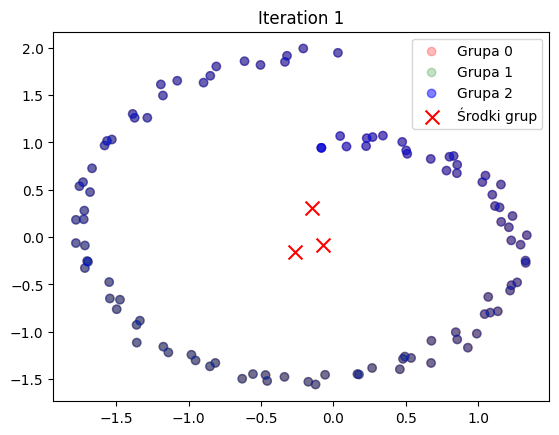

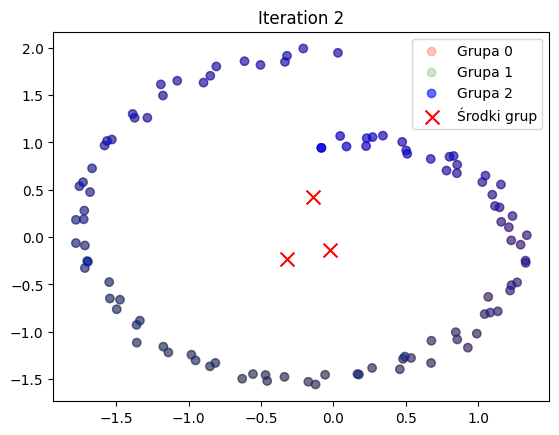

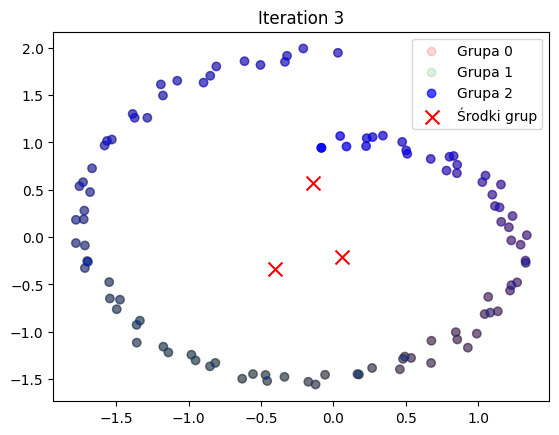

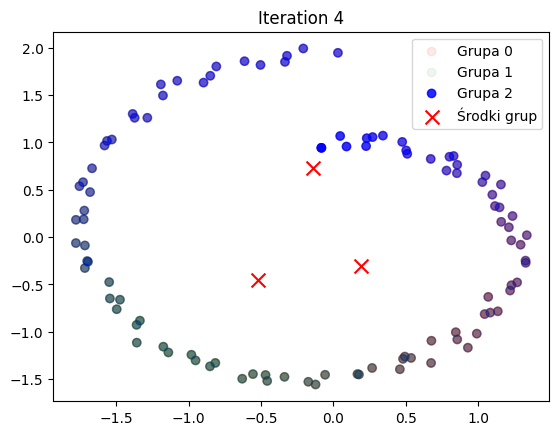

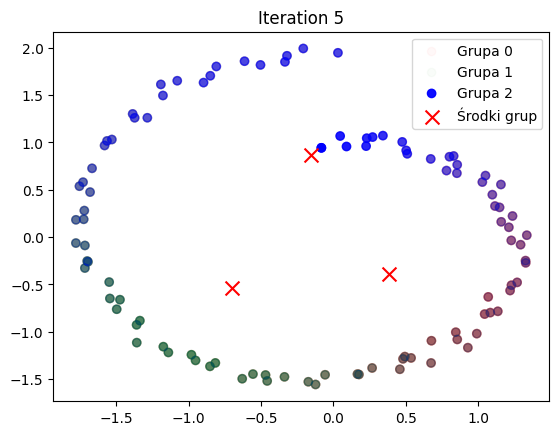

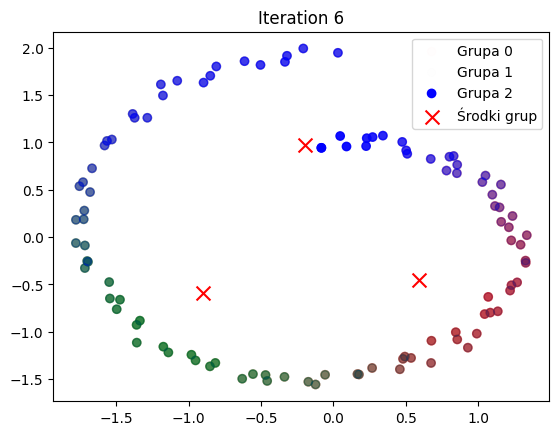

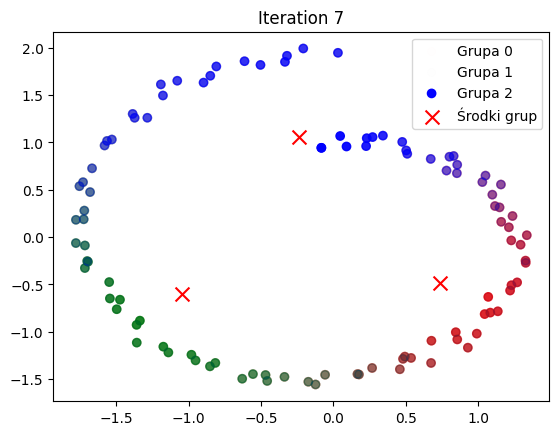

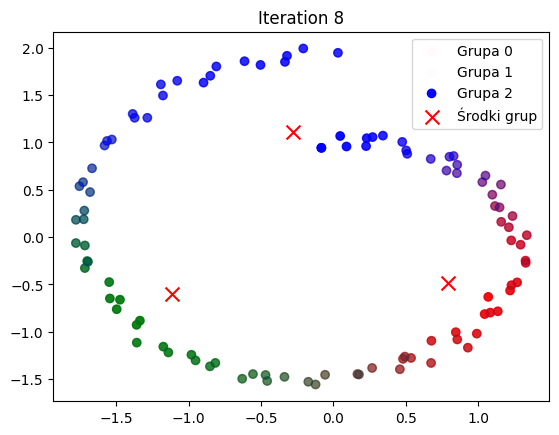

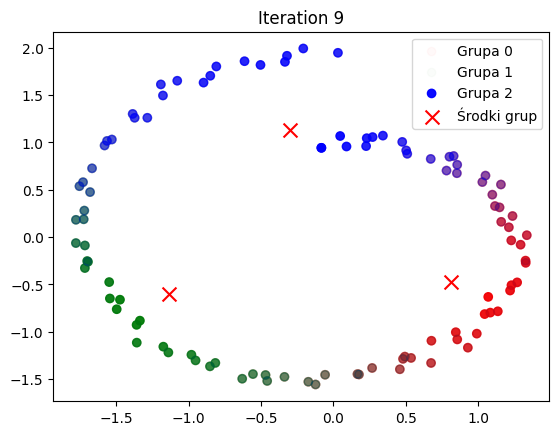

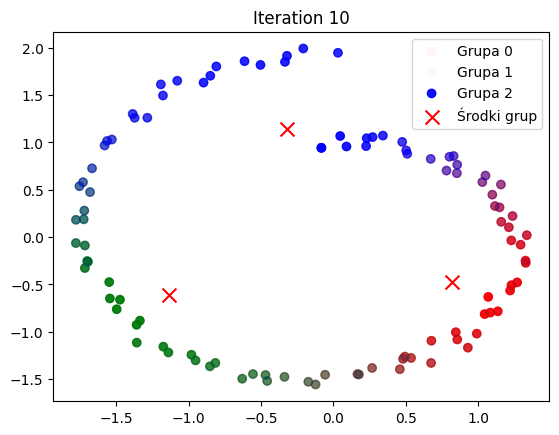

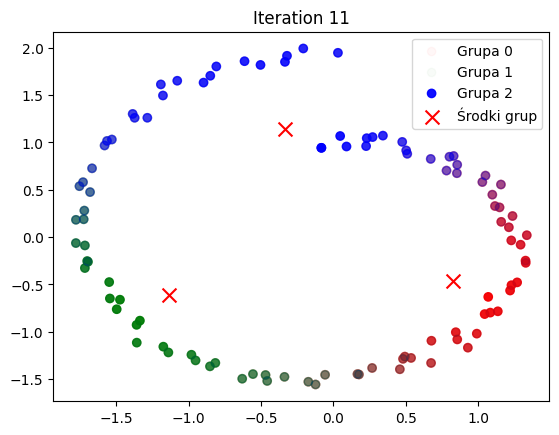

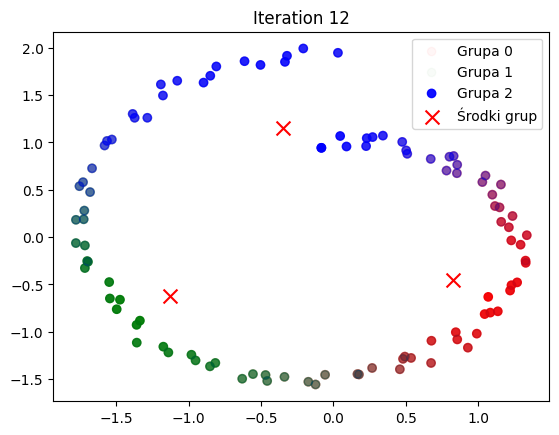

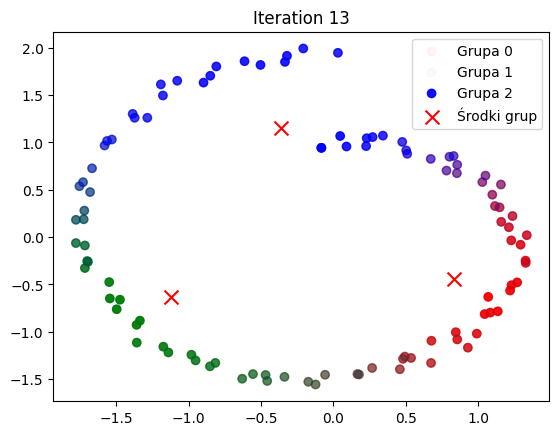

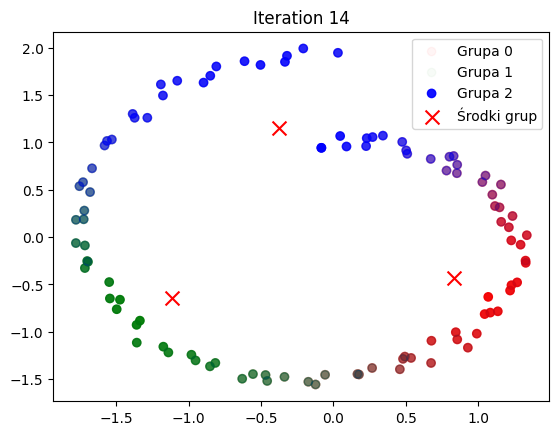

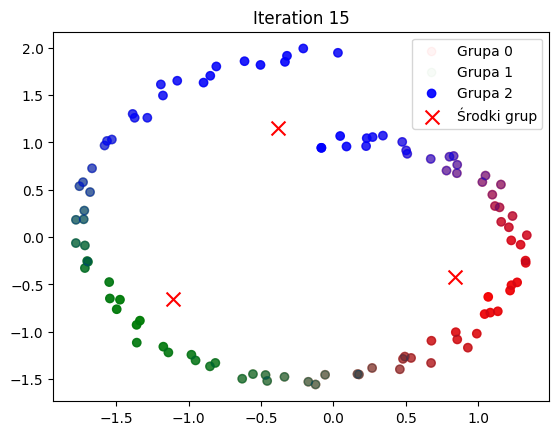

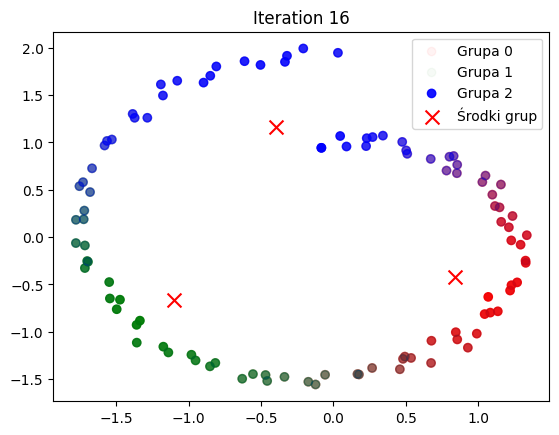

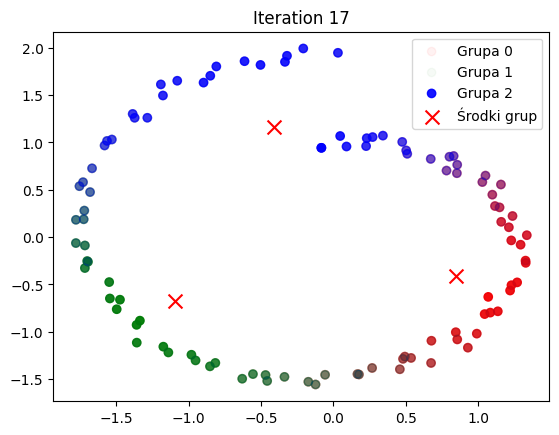

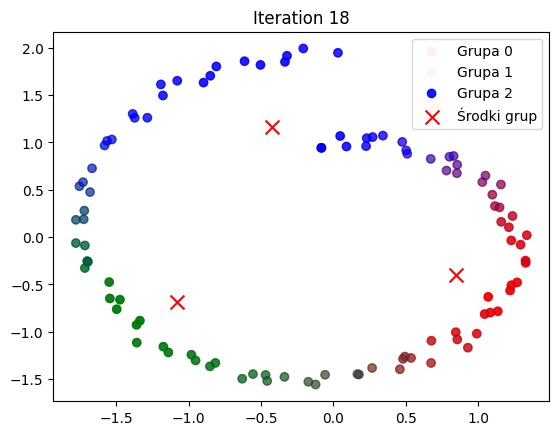

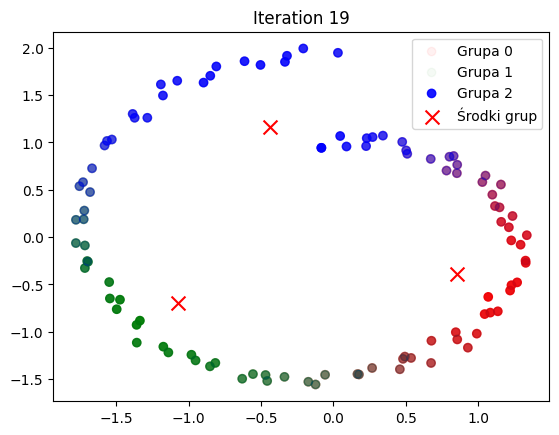

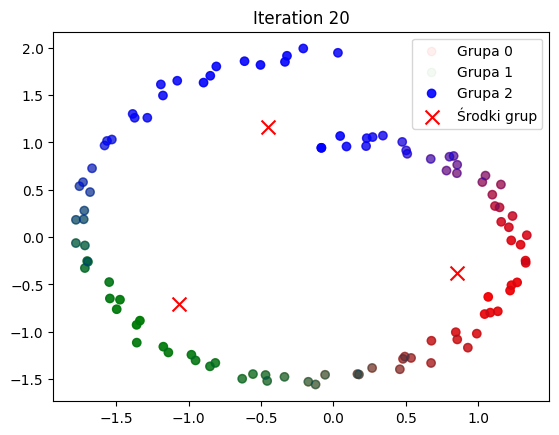

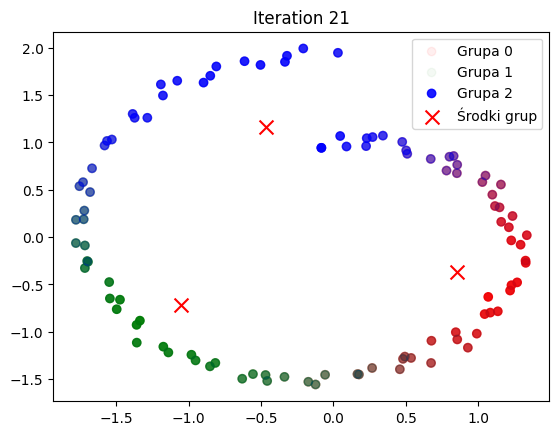

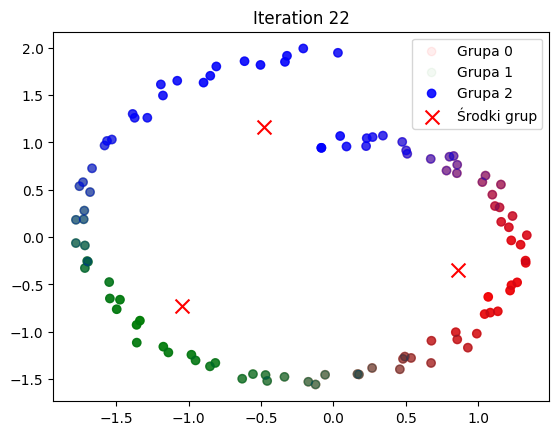

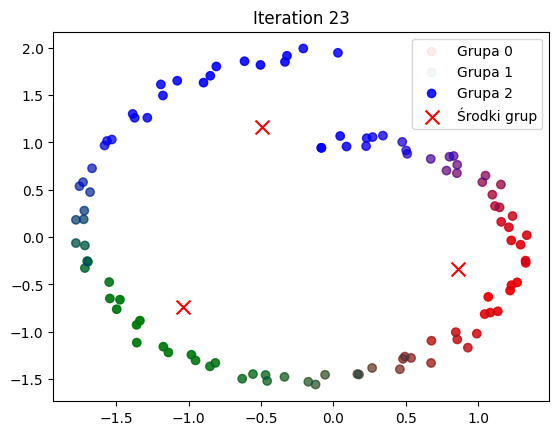

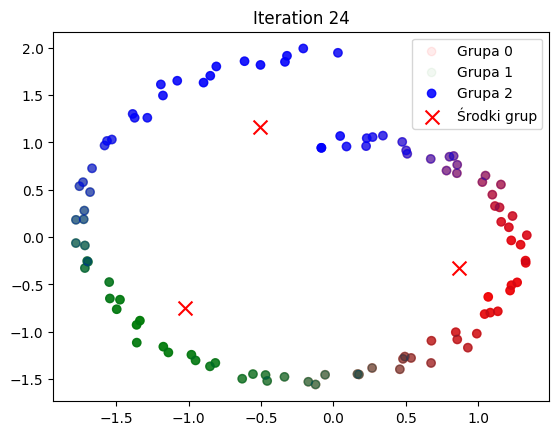

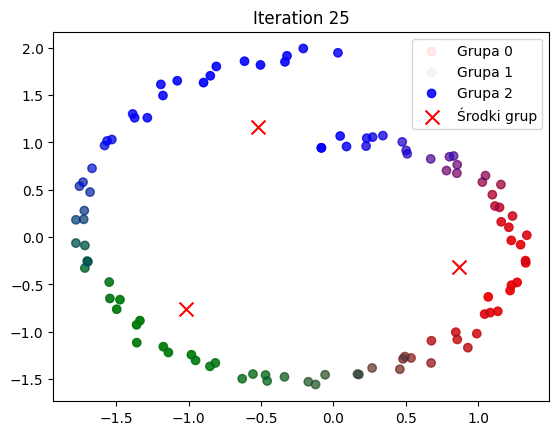

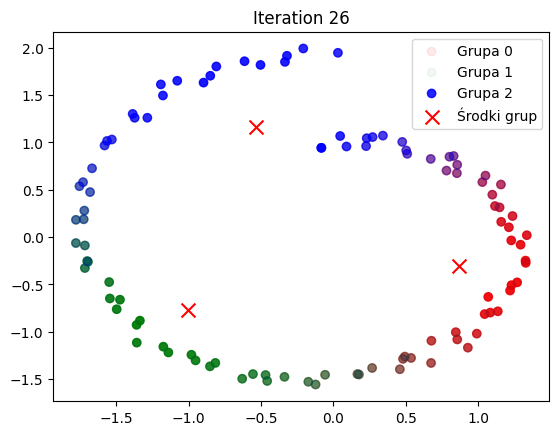

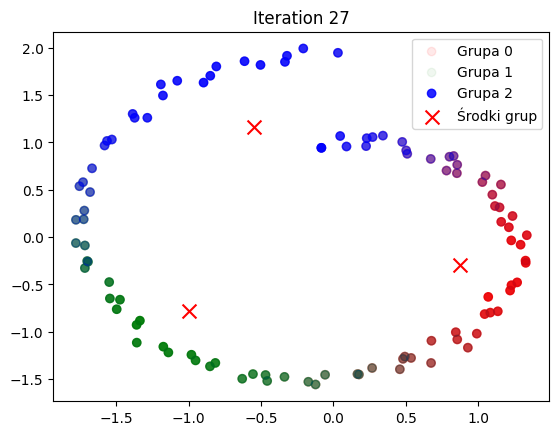

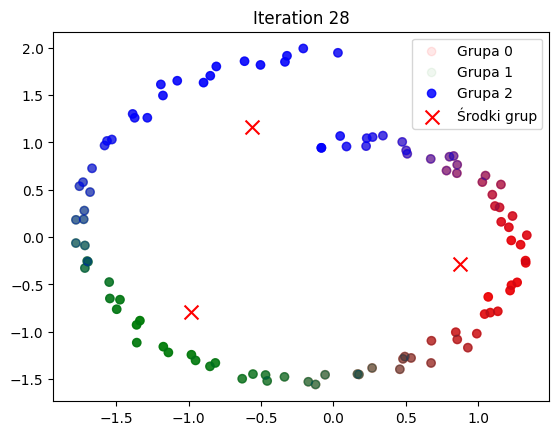

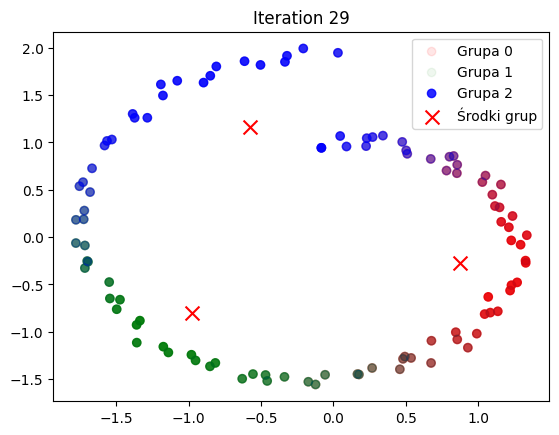

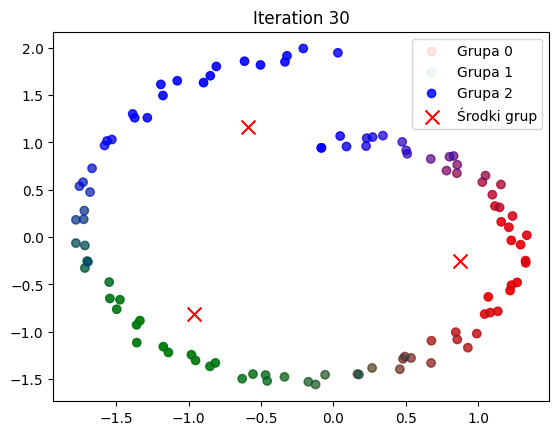

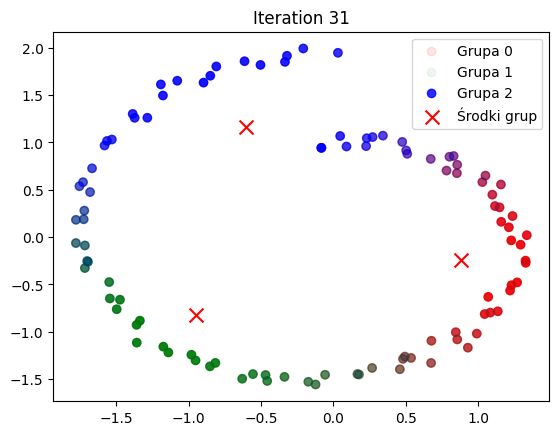

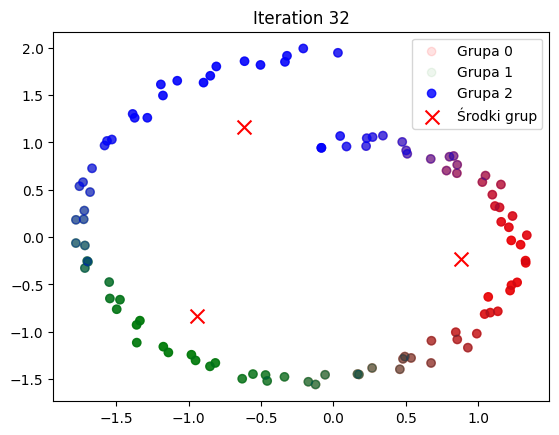

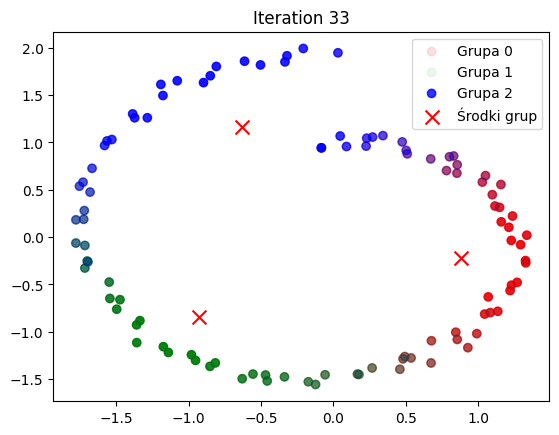

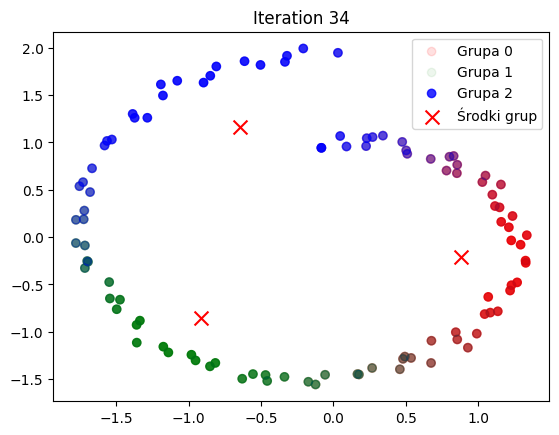

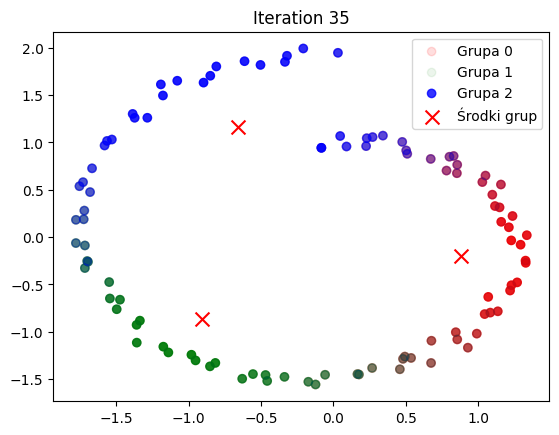

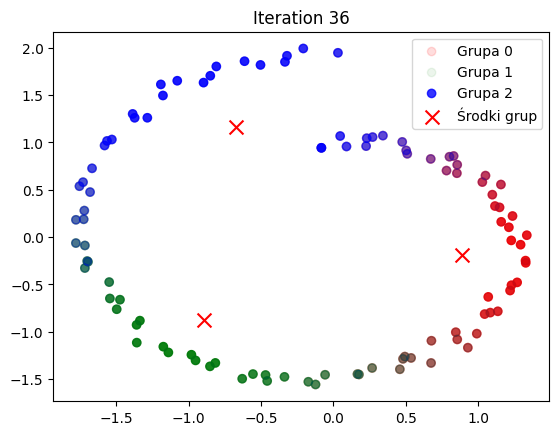

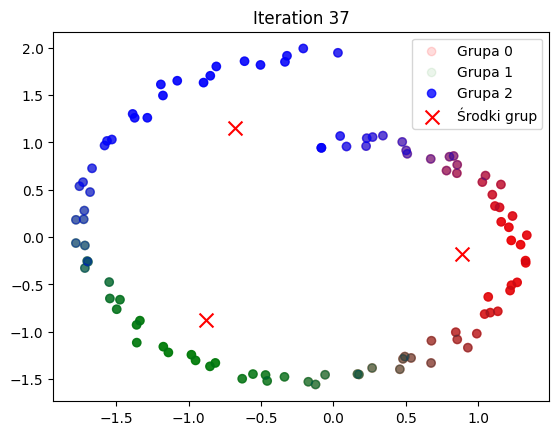

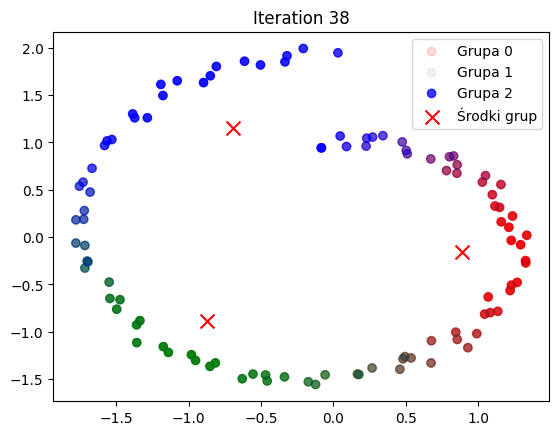

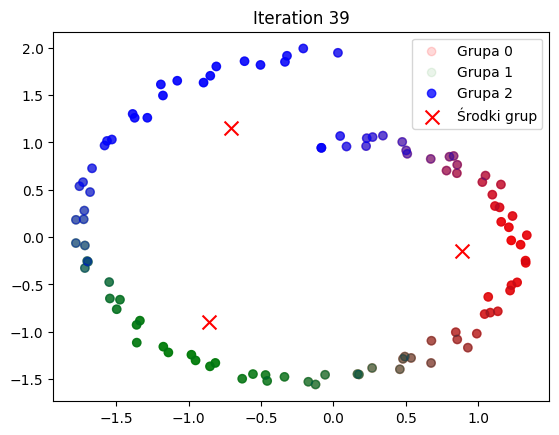

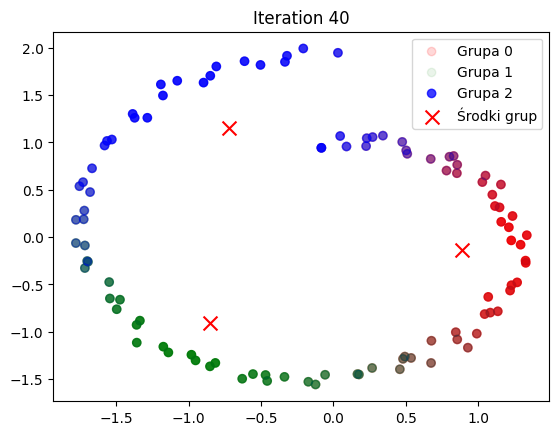

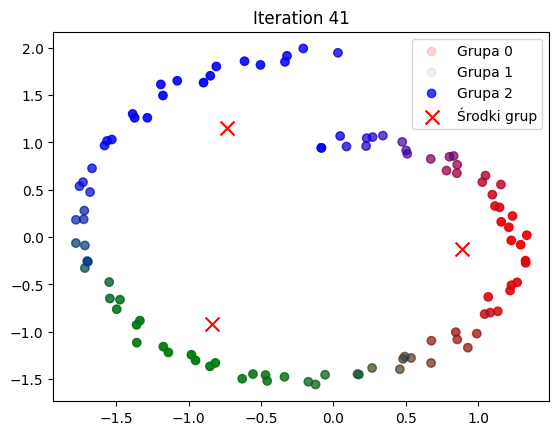

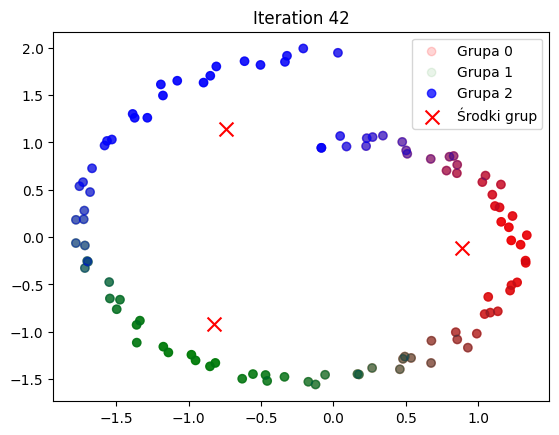

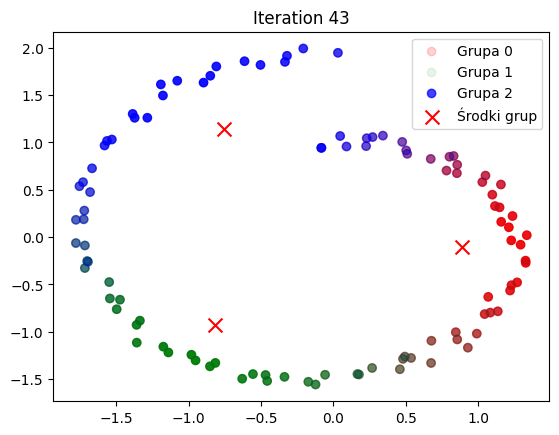

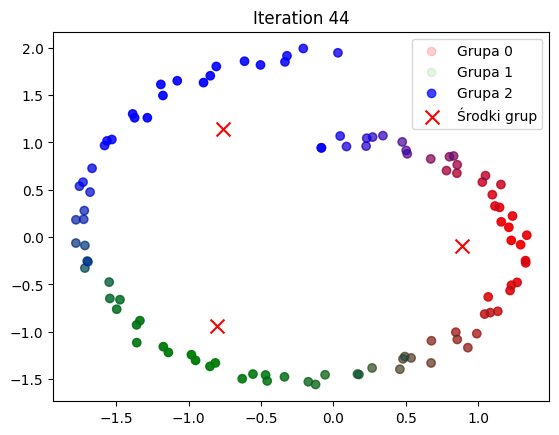

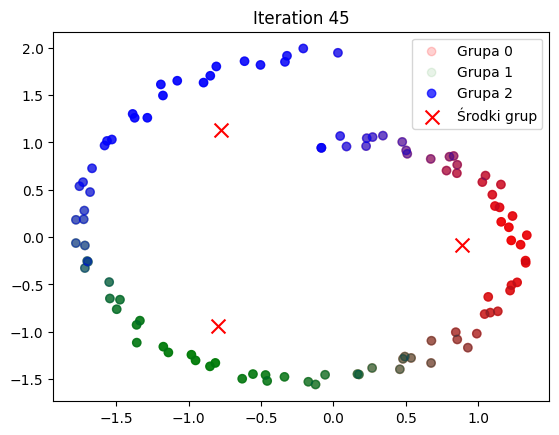

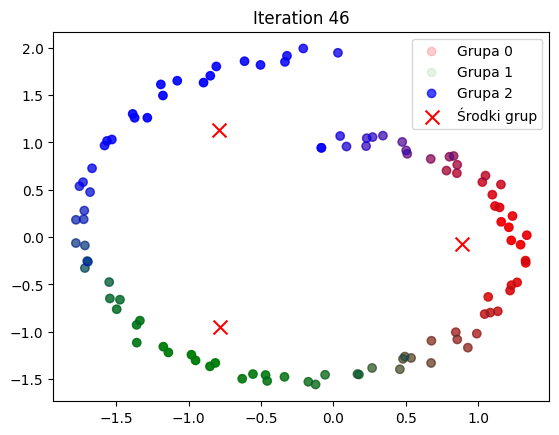

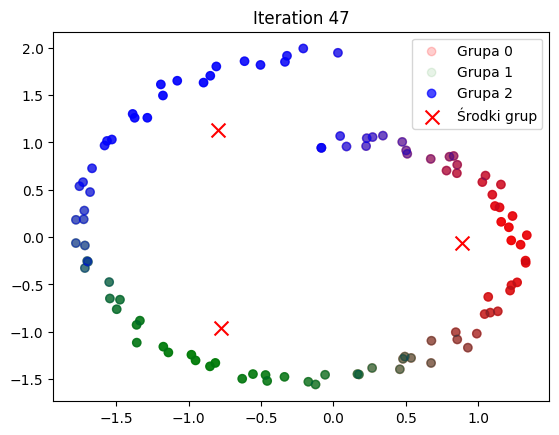

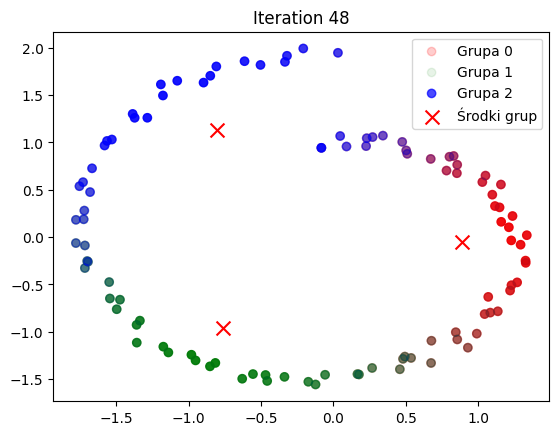

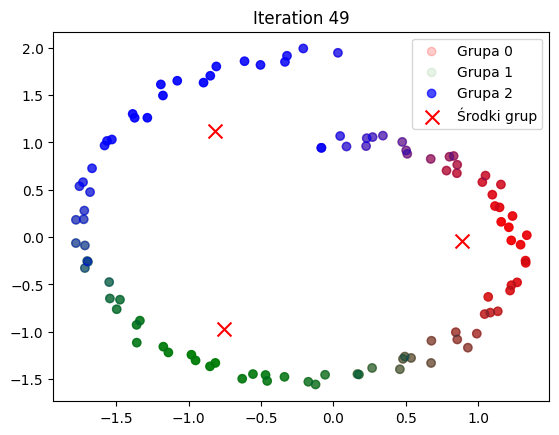

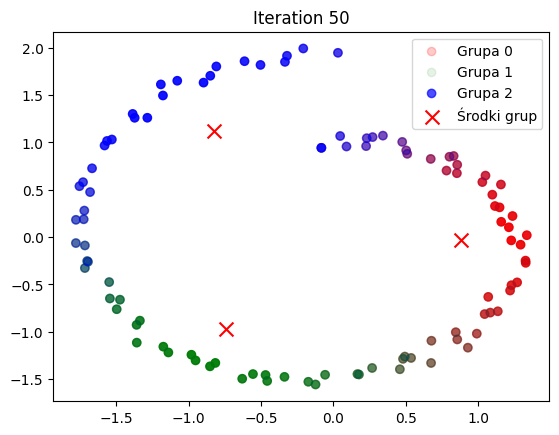

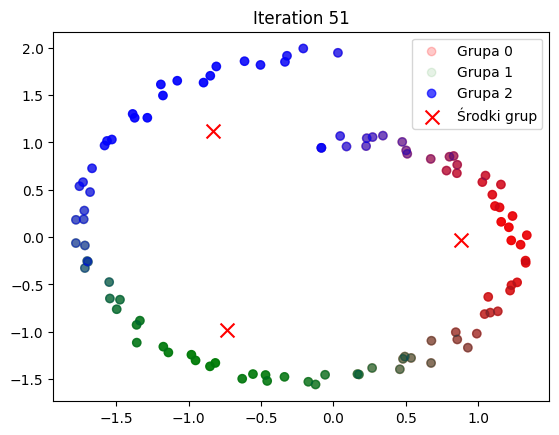

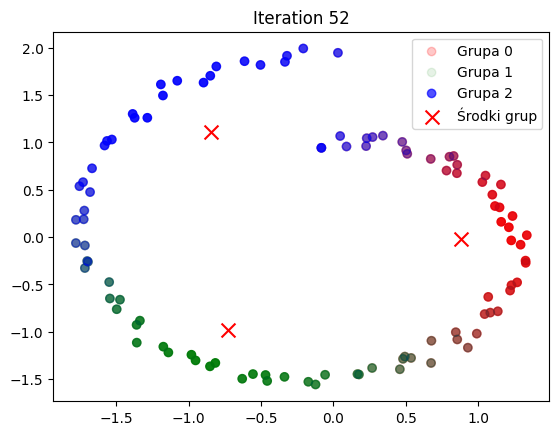

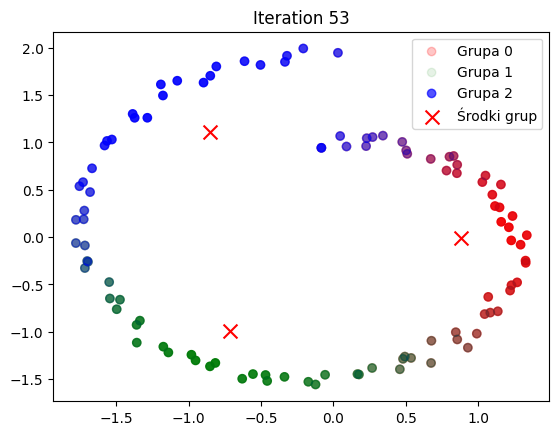

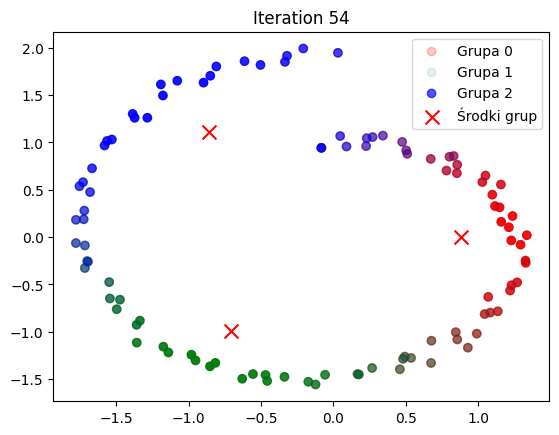

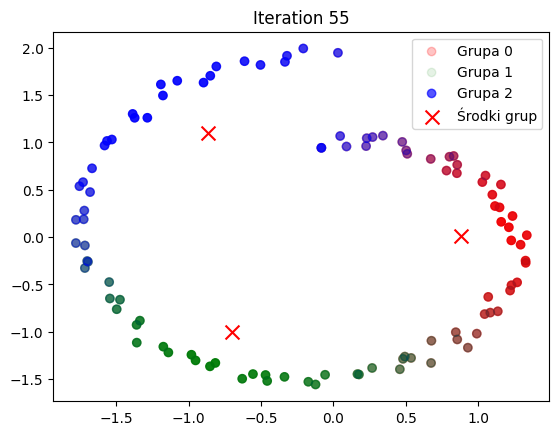

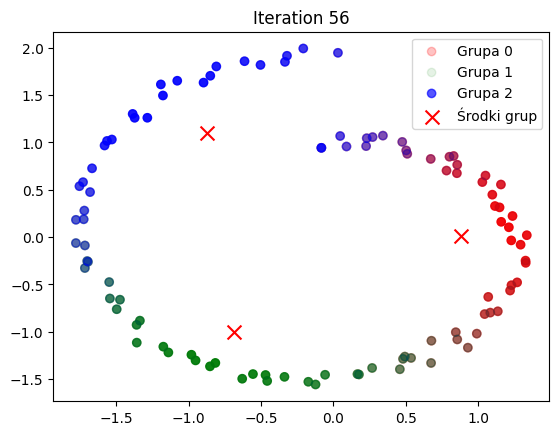

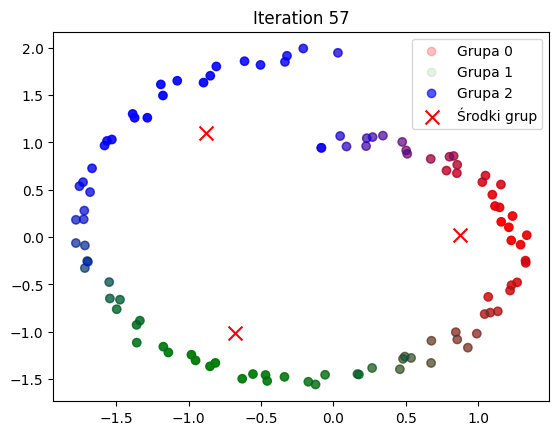

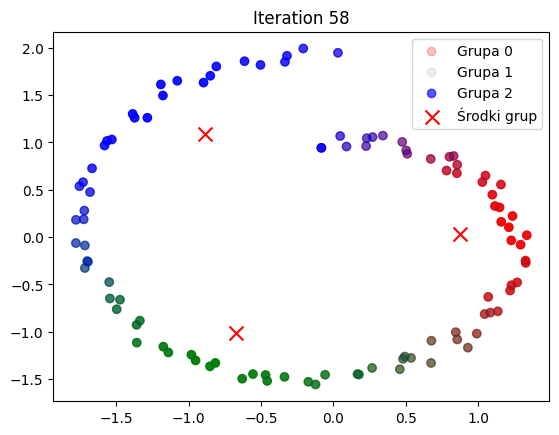

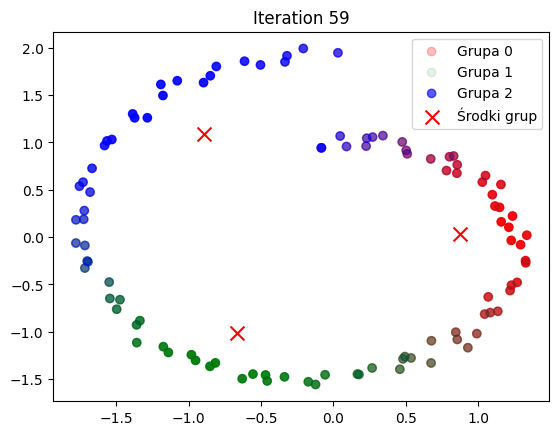

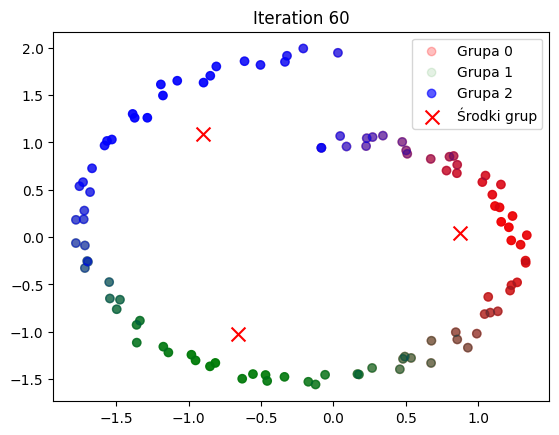

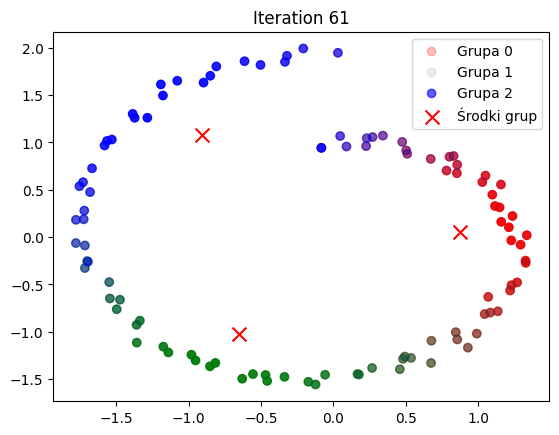

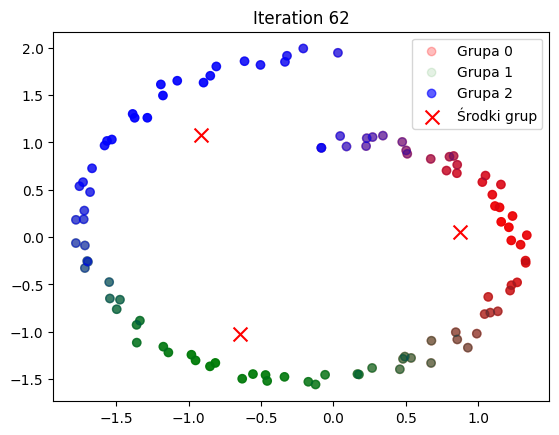

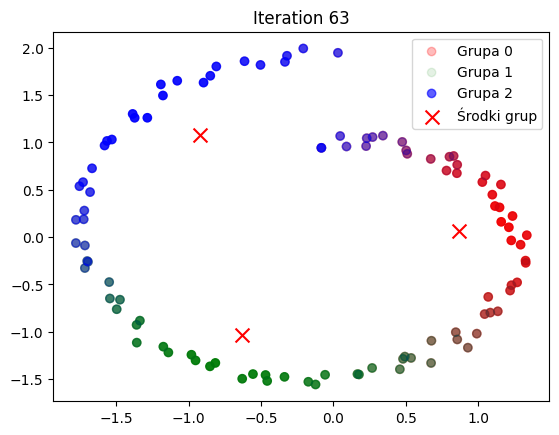

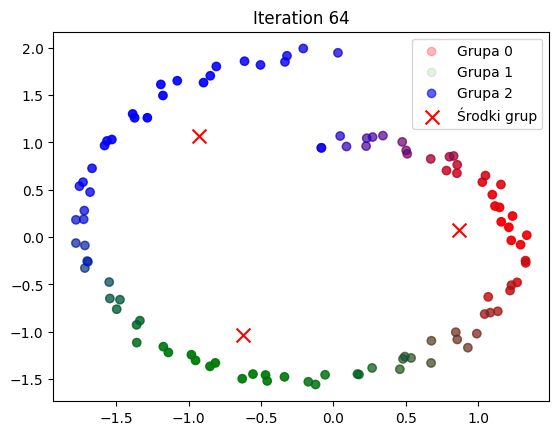

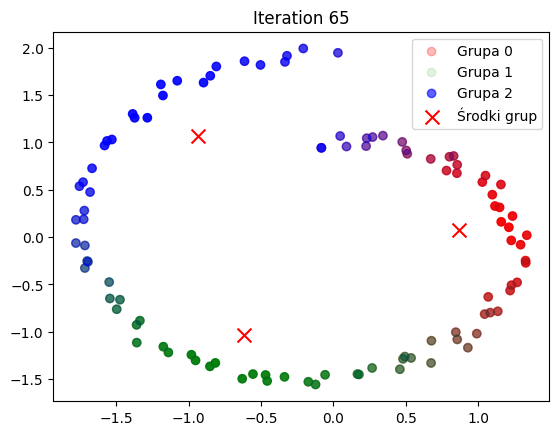

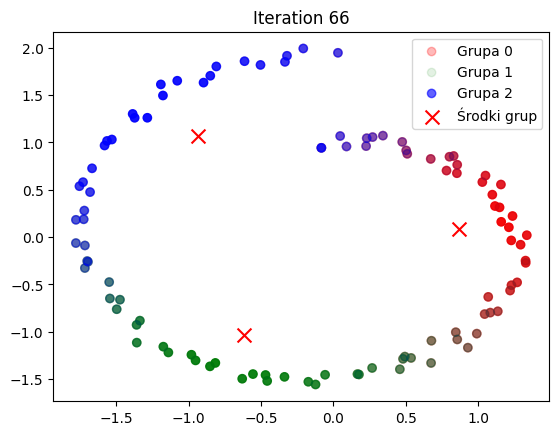

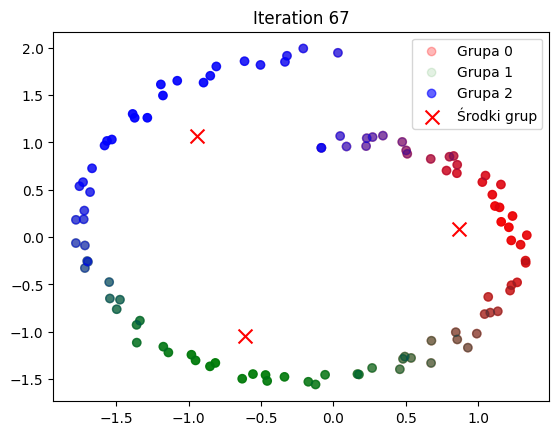

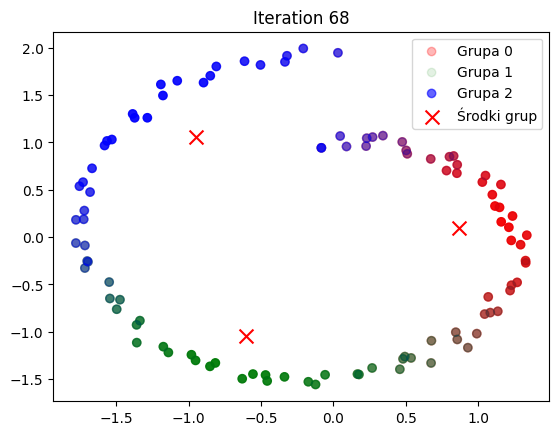

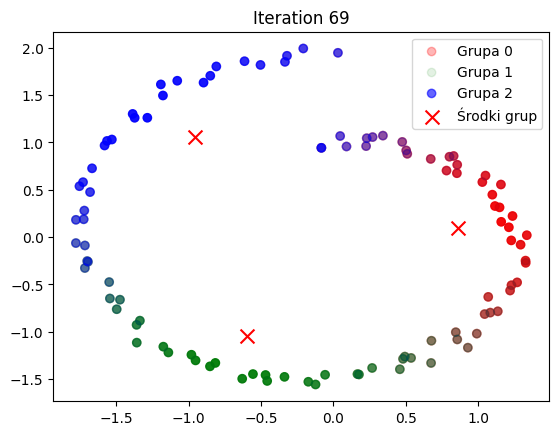

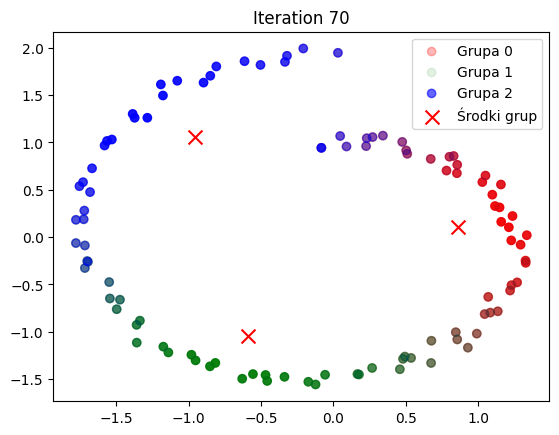

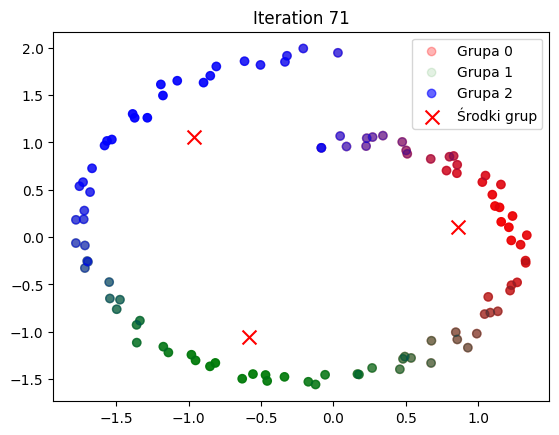

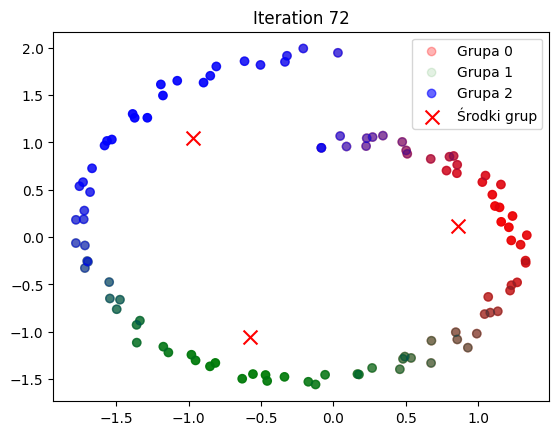

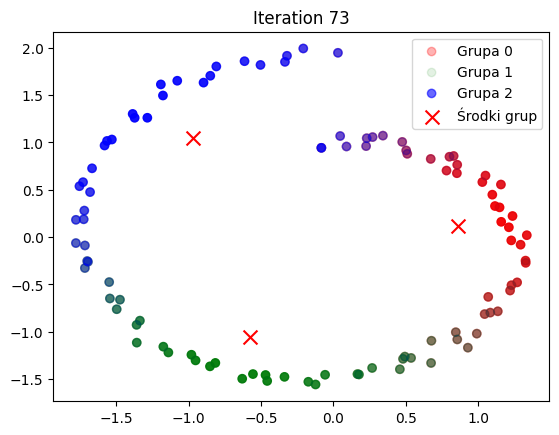

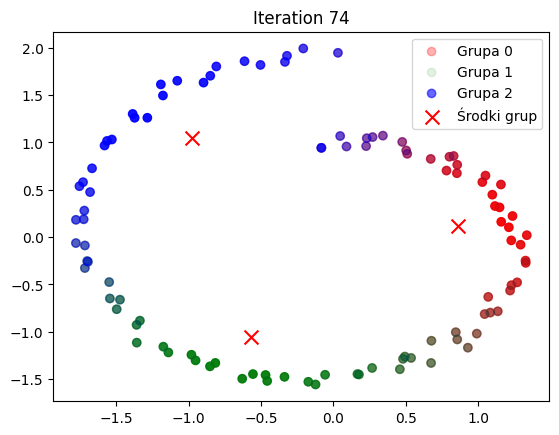

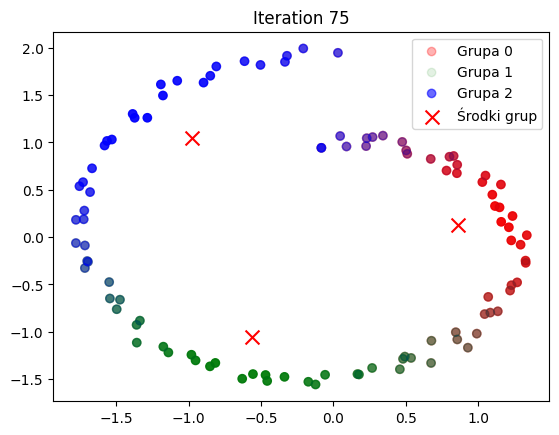

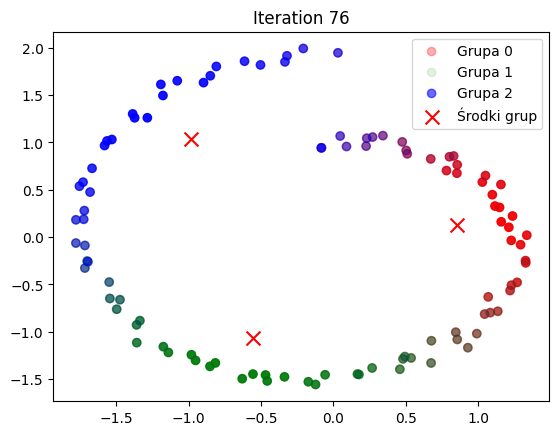

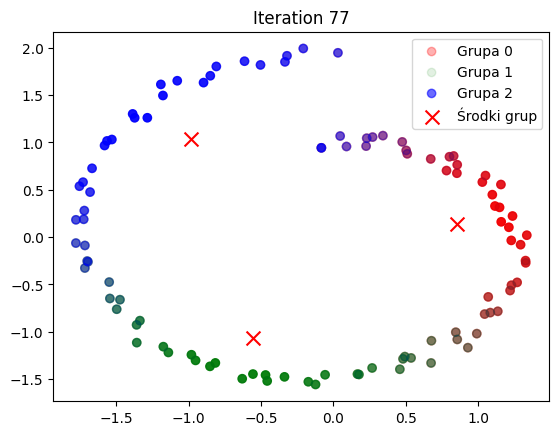

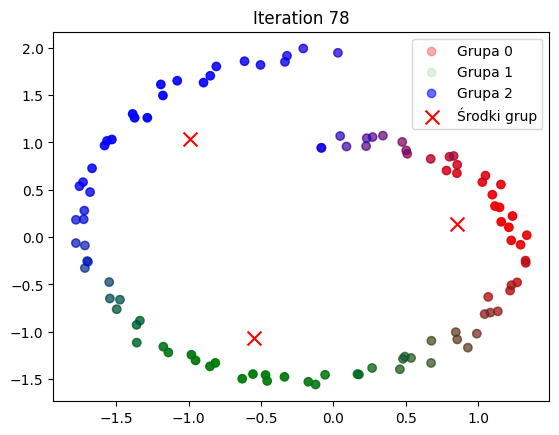

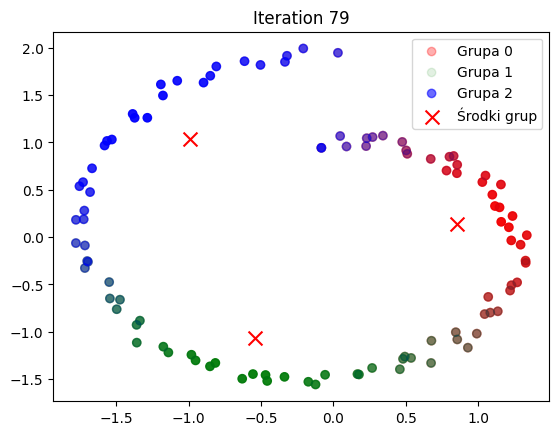

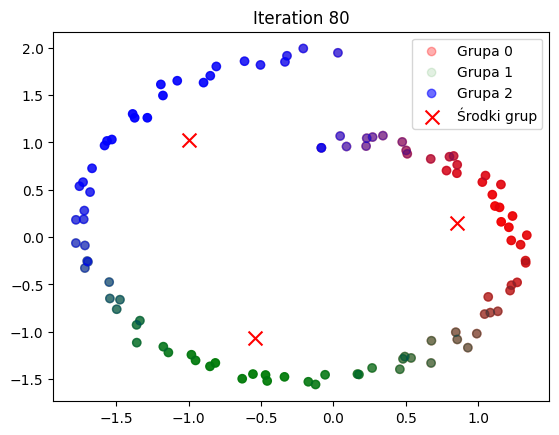

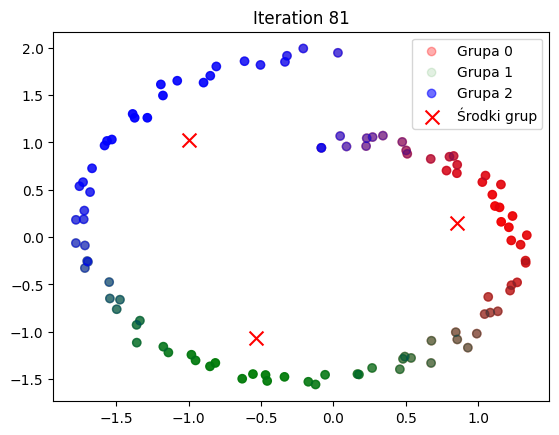

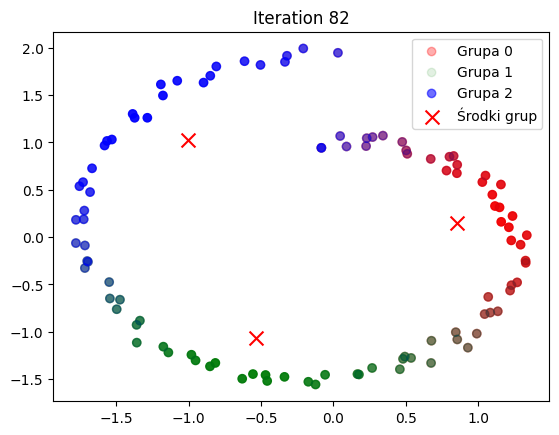

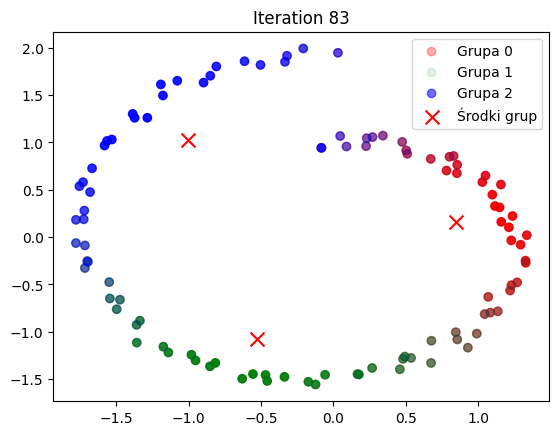

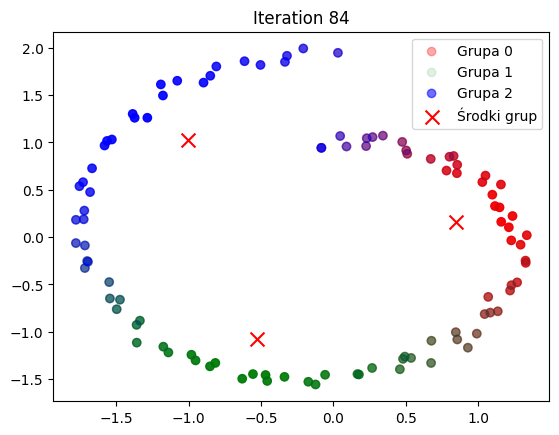

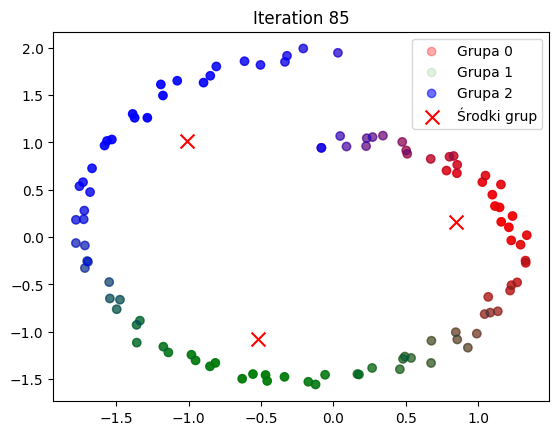

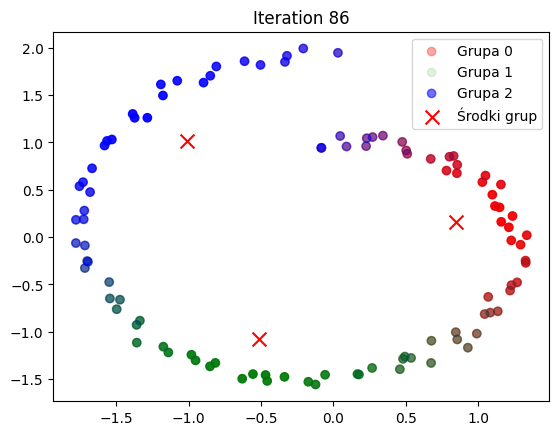

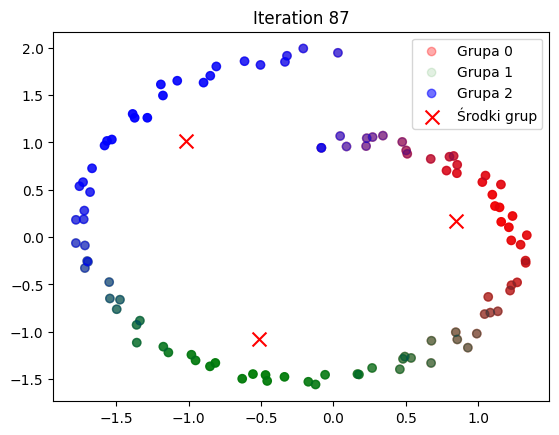

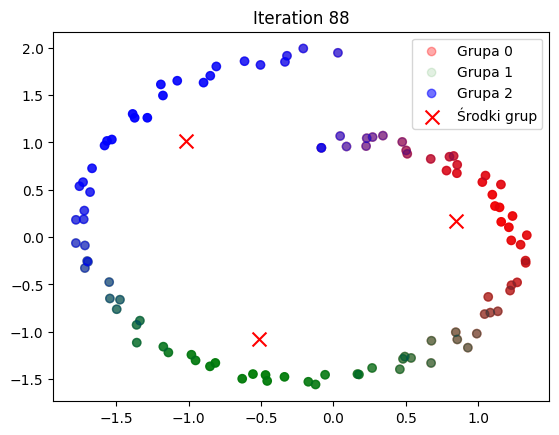

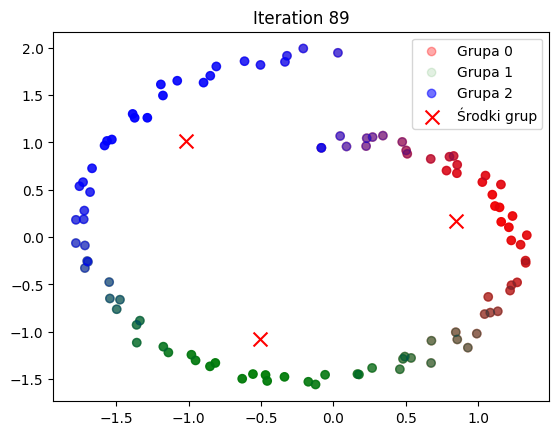

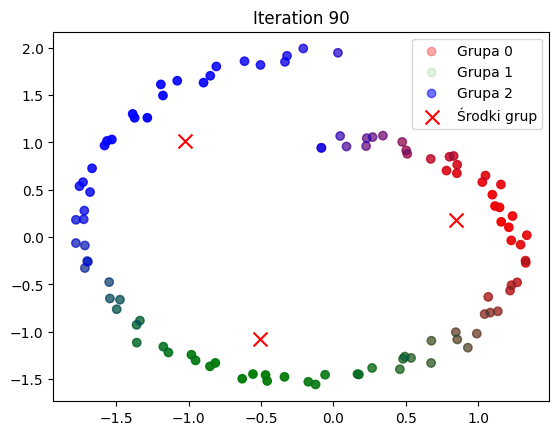

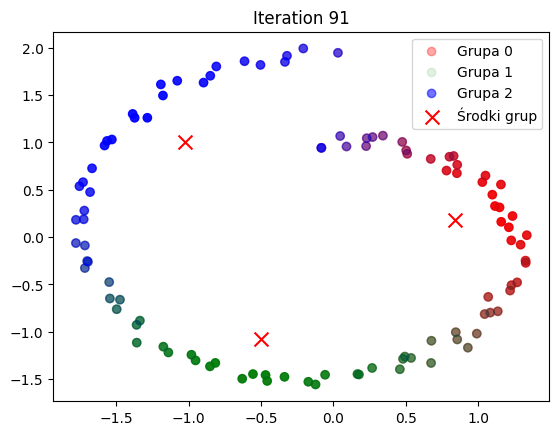

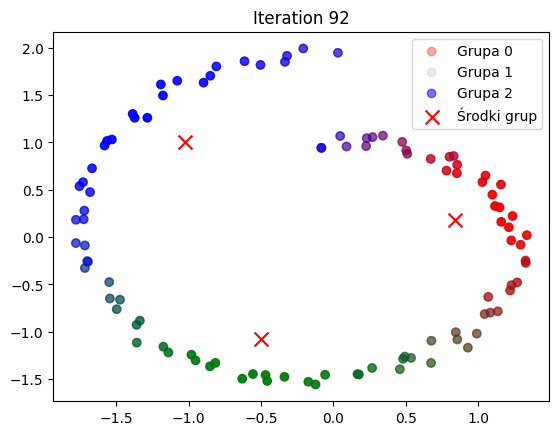

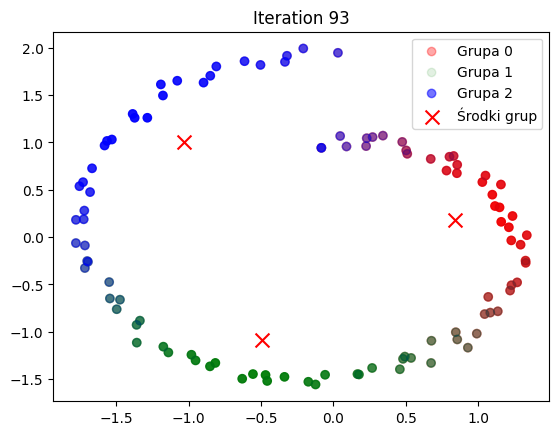

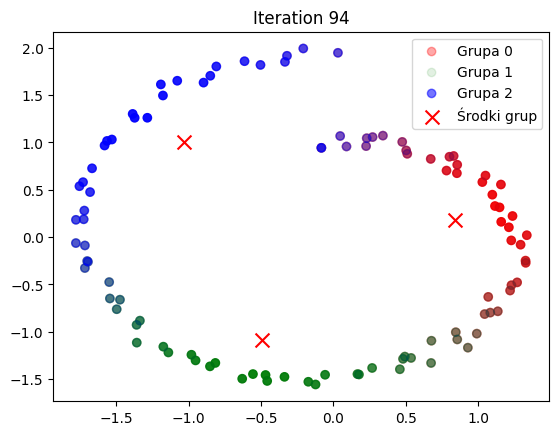

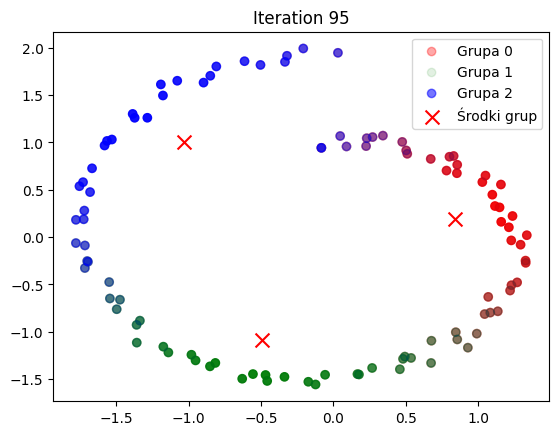

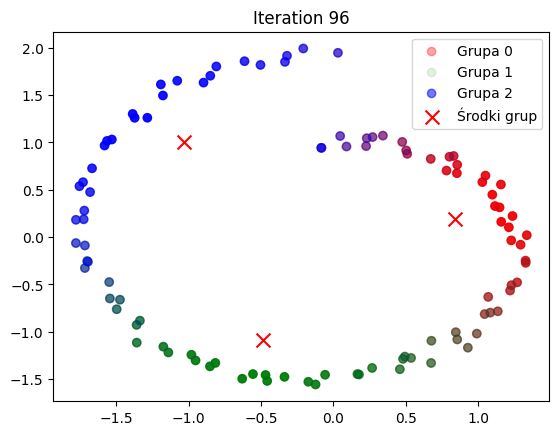

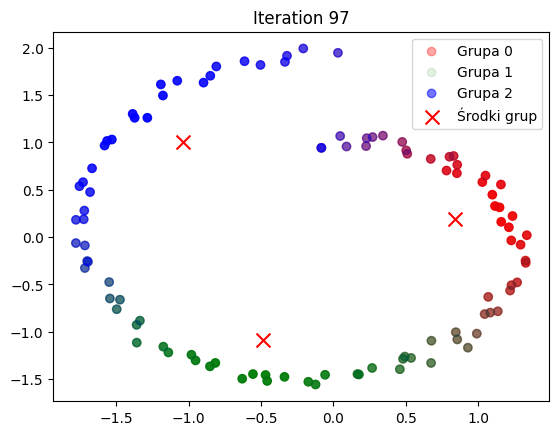

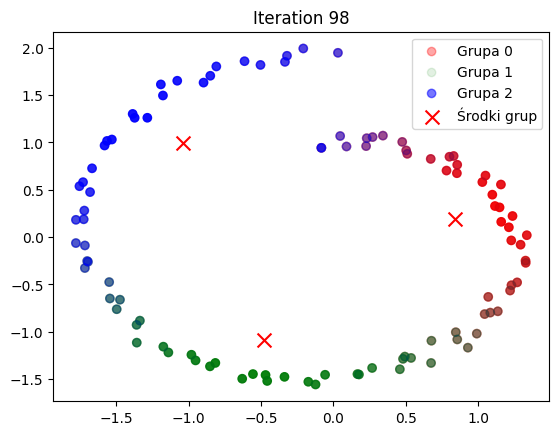

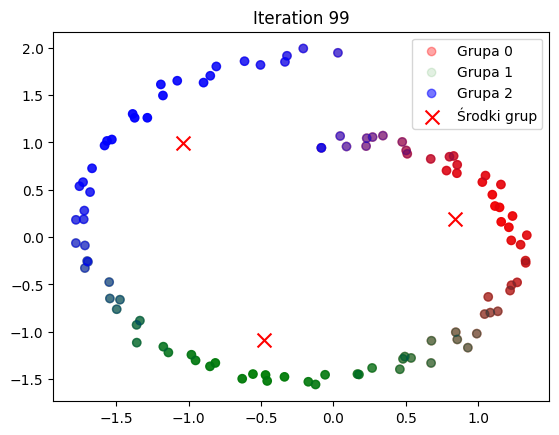

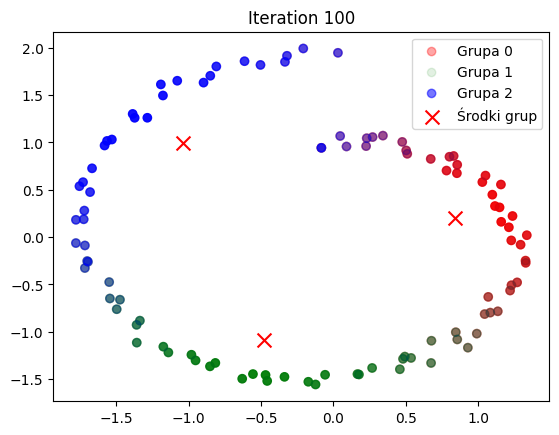

In [12]:
U = calculate_membership_matrix(U=U, D=D, m=m, M=M)  # 1.4 Wyliczenie każdej wartości w tablicy Uj,s
V = calculate_group_middle_points(V=V, U=U, df=df, m=m, n=n, M=M)  # 1.5 Obliczenie środków grup Vj,i

for iteration in range(iters):  # 2. Główna pętla programu wykonywana przez zadaną liczbę iteracji
    D = calculate_distances(D=D, V=V, df=df, m=m, M=M)  # 2.1. Obliczenie odległości między każdą próbką a grupą: Dj,s
    D = np.where(D < 1e-10, 1e-10, D)  # 2.2. Należy zadbać, aby wszystkie wartości w tablicy D były większe od ustalonej małej wartości
    U = calculate_membership_matrix(U=U, D=D, m=m, M=M)  # 2.3. Wyliczenie stopnia przynależności poszczególnej próbki do każdej grupy: Uj,s

    if np.isnan(U).any():  # 2.4. Należy sprawdzić, czy przypadkiem U nie zawiera wartości nieoznaczonych
        raise ValueError('Macierz U zawiera nieoznaczone wartości (NaN).')

    V = calculate_group_middle_points(V=V, U=U, df=df, m=m, n=n, M=M)  # 2.5. Obliczenie nowych położeń środków grup Vj,i

    draw_current_iteration(df=df, V=V, U=U, m=m, iteration=iteration + 1)